## 0 - Exploratory Data Analysis

Some global plotting options that we use.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    # --- Figure ---
    "figure.figsize": (6, 4),
    "figure.dpi": 300,

    # --- Fonts ---
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "font.family": "serif",       # or "sans-serif"
    "mathtext.fontset": "stix",   # clean math font

    # --- Axes ---
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.grid": False,

    # --- Ticks ---
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.major.width": 0.7,
    "ytick.major.width": 0.7,

    # --- Legend ---
    "legend.fontsize": 10,
    "legend.frameon": False,

    # --- Colors / Colormap ---
    "image.cmap": "viridis",
})

1. Load and preprocess both the CTM-based and embeddings datasets

Some utility functions below.

In [2]:
import os
os.chdir("..")

In [3]:
from utils.load import load_embeddings_dataset, load_ctms_dataset

embeddings_dfs = load_embeddings_dataset("data/videogame_embeddings/embedding_dataset.parquet")
ctms_df = load_ctms_dataset("data/videogame_sequences/sequence_dataset.parquet")

In [26]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from typing import Optional
from loguru import logger

from utils.mahalanobis import mahalanobis_mask

def embedding_to_array(series: pd.Series) -> np.ndarray:
    """Convert Series of embedding arrays into a stacked ndarray."""
    return np.vstack(series.to_numpy())

def ctm_to_array(ctm_series: pd.Series) -> np.ndarray:
    """Convert CTMs into a stacked 2D array."""
    return np.vstack([
        ctm.flatten() if isinstance(ctm, np.ndarray) else ctm
        for ctm in ctm_series
    ])
    
def preprocess_ctms(
    df: pd.DataFrame,
    n_components: Optional[int] = None,
    remove_outliers: bool = True,
    alpha: float = 0.001  # significance level for Mahalanobis
):
    X = ctm_to_array(df["ctm"])

    # Standardize
    X_scaled = StandardScaler().fit_transform(X)

    # PCA: keep 90% variance
    pca_full = PCA().fit(X_scaled)
    cum = np.cumsum(pca_full.explained_variance_ratio_)
    k = np.argmax(cum >= 0.90) + 1
    logger.info(f"CTMs: PCA -> {k} dims (≥90% variance)")

    if n_components is not None:
        k = n_components
   
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_scaled)

    if remove_outliers:
        mask, d2, threshold = mahalanobis_mask(X_pca, alpha=alpha)
        logger.info(f"Removed {(~mask).sum()} outliers (Mahalanobis, χ² threshold={threshold:.2f})")
        return df[mask].reset_index(drop=True), X_pca[mask]

    return df.reset_index(drop=True), X_pca

def preprocess_embeddings(
    df: pd.DataFrame,
    model_name: str,
    remove_outliers: bool = True,
    n_components: Optional[int] = None,
    alpha: float = 0.01,
):
    """
    Convert embeddings -> standardize -> PCA until ≥90% variance -> optional outlier filtering.

    Output:
        filtered_df, X_pca (2D ndarray)
    """
    df = df.copy()

    # Extract embedding matrix
    X = embedding_to_array(df[model_name])
    logger.info(f"PCA on {model_name} embeddings, original dim={X.shape[1]}")

    # Standardize
    X_scaled = StandardScaler().fit_transform(X)

    # PCA full, then select cutoff at geq 90% explained variance
    pca_full = PCA().fit(X_scaled)
    cum = np.cumsum(pca_full.explained_variance_ratio_)
    k = np.argmax(cum >= 0.90) + 1
    logger.info(f"{model_name}: PCA -> {k} dims (≥90% variance)")
    
    if n_components is not None:
        k = min(k, n_components)
        logger.info(f"{model_name}: PCA limited to {k} dims (n_components={n_components})")

    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_scaled)
    # reduce to float32 to save memory
    X_pca = X_pca.astype(np.float32)

    # Optional outlier removal in PCA space
    if remove_outliers:
        mask, d2, threshold = mahalanobis_mask(X_pca, alpha=alpha)
        logger.info(f"Removed {(~mask).sum()} outliers (pct removed: {(~mask).mean()*100:.2f}%) (Mahalanobis, χ² threshold={threshold:.2f})")
        return df[mask].reset_index(drop=True), X_pca[mask]

    return df.reset_index(drop=True), X_pca

def outlier_removal_test(X: np.ndarray, alphas=[0.05, 0.01, 0.001], n_components=None):
    """
    Test different alpha levels for Mahalanobis outlier removal.
    Print number and percentage of outliers removed for each alpha.
    """
    # apply pca
    pca = PCA(n_components=n_components).fit(X)
    X_pca = pca.transform(X)
    n_samples = X.shape[0]
    for alpha in alphas:
        mask, d2, threshold = mahalanobis_mask(X_pca, alpha=alpha)
        n_outliers = (~mask).sum()
        pct_outliers = (n_outliers / n_samples) * 100
        logger.info(f"Alpha={alpha}: Removed {n_outliers} outliers ({pct_outliers:.2f}%) with χ² threshold={threshold:.2f}")

1. Relative sizes of each representation

In [5]:
X_ctm = ctm_to_array(ctms_df["ctm"])
X_clap = embedding_to_array(embeddings_dfs["clap"])
X_ast = embedding_to_array(embeddings_dfs["ast"])
X_wavlm = embedding_to_array(embeddings_dfs["wavlm"])

# compare sizes

print(f"""
CTM shape: {X_ctm.shape}, size: {X_ctm.nbytes / 1e6:.2f} MB
CLAP shape: {X_clap.shape}, size: {X_clap.nbytes / 1e6:.2f} MB
AST shape: {X_ast.shape}, size: {X_ast.nbytes / 1e6:.2f} MB
WavLM shape: {X_wavlm.shape}, size: {X_wavlm.nbytes / 1e6:.2f} MB  
""")


CTM shape: (3320, 16641), size: 220.99 MB
CLAP shape: (3332, 1024), size: 13.65 MB
AST shape: (3332, 1536), size: 20.47 MB
WavLM shape: (3332, 1536), size: 20.47 MB  



2. CTM heatmaps

In [6]:
def plot_ctm_heatmap(ctm_array: np.ndarray, title: str = "CTM Heatmap"):
    ctm_array = ctm_array.reshape(129, 129)
    plt.figure(figsize=(6, 6))
    plt.imshow(ctm_array.T, aspect='equal', origin='lower', cmap='hot')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Chord 1')
    plt.ylabel('Chord 2')
    plt.tight_layout()
    plt.show()

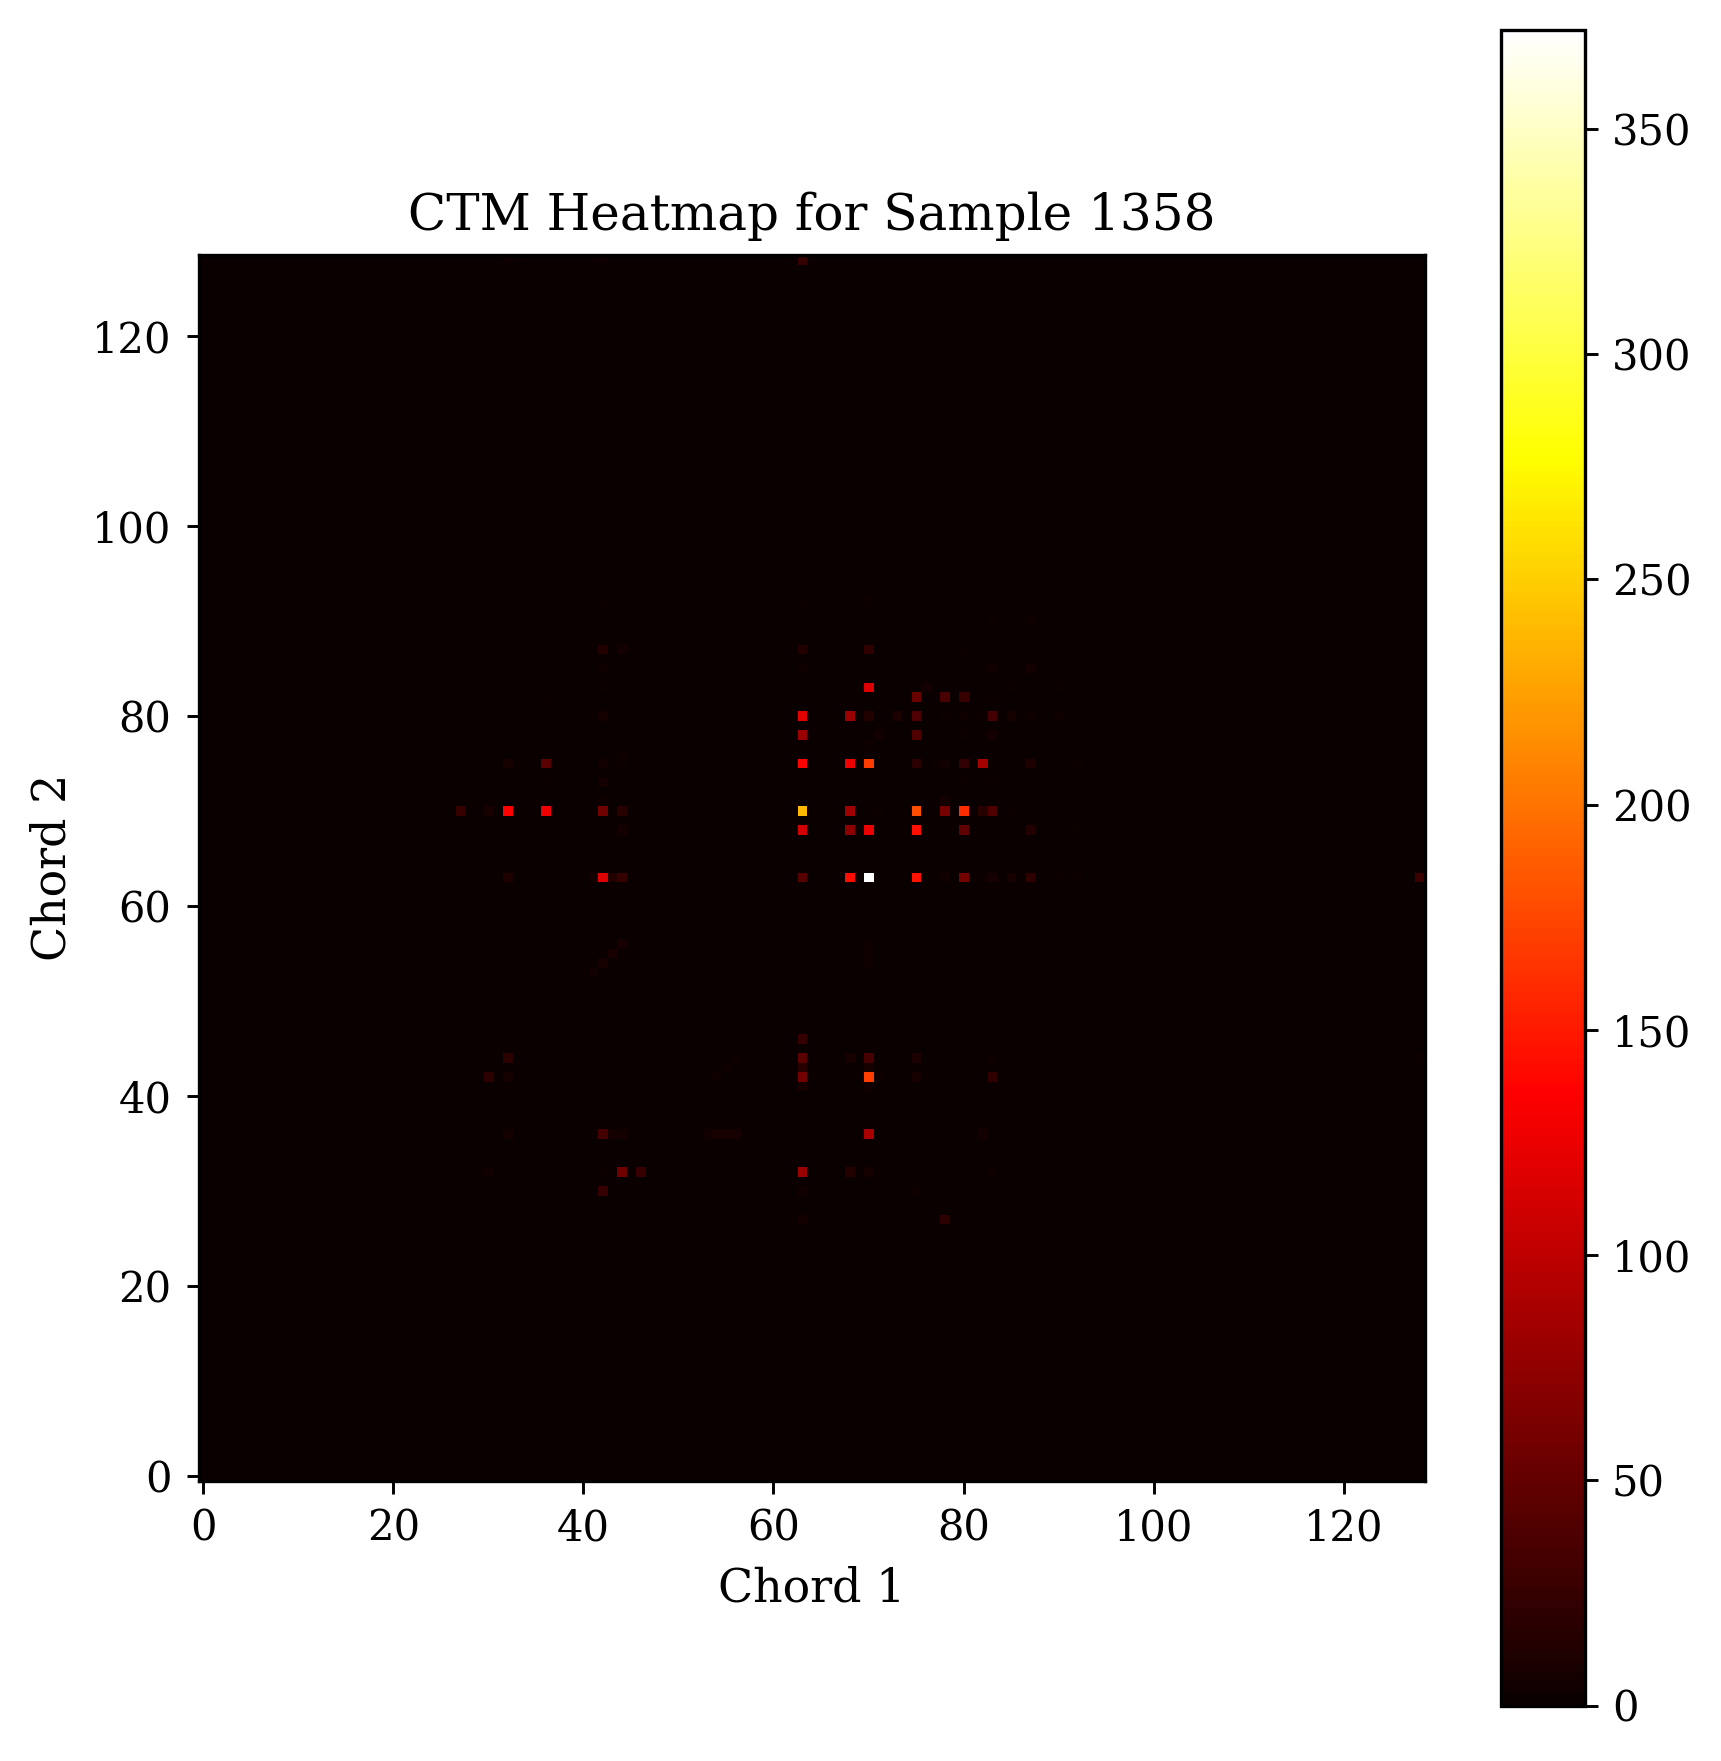

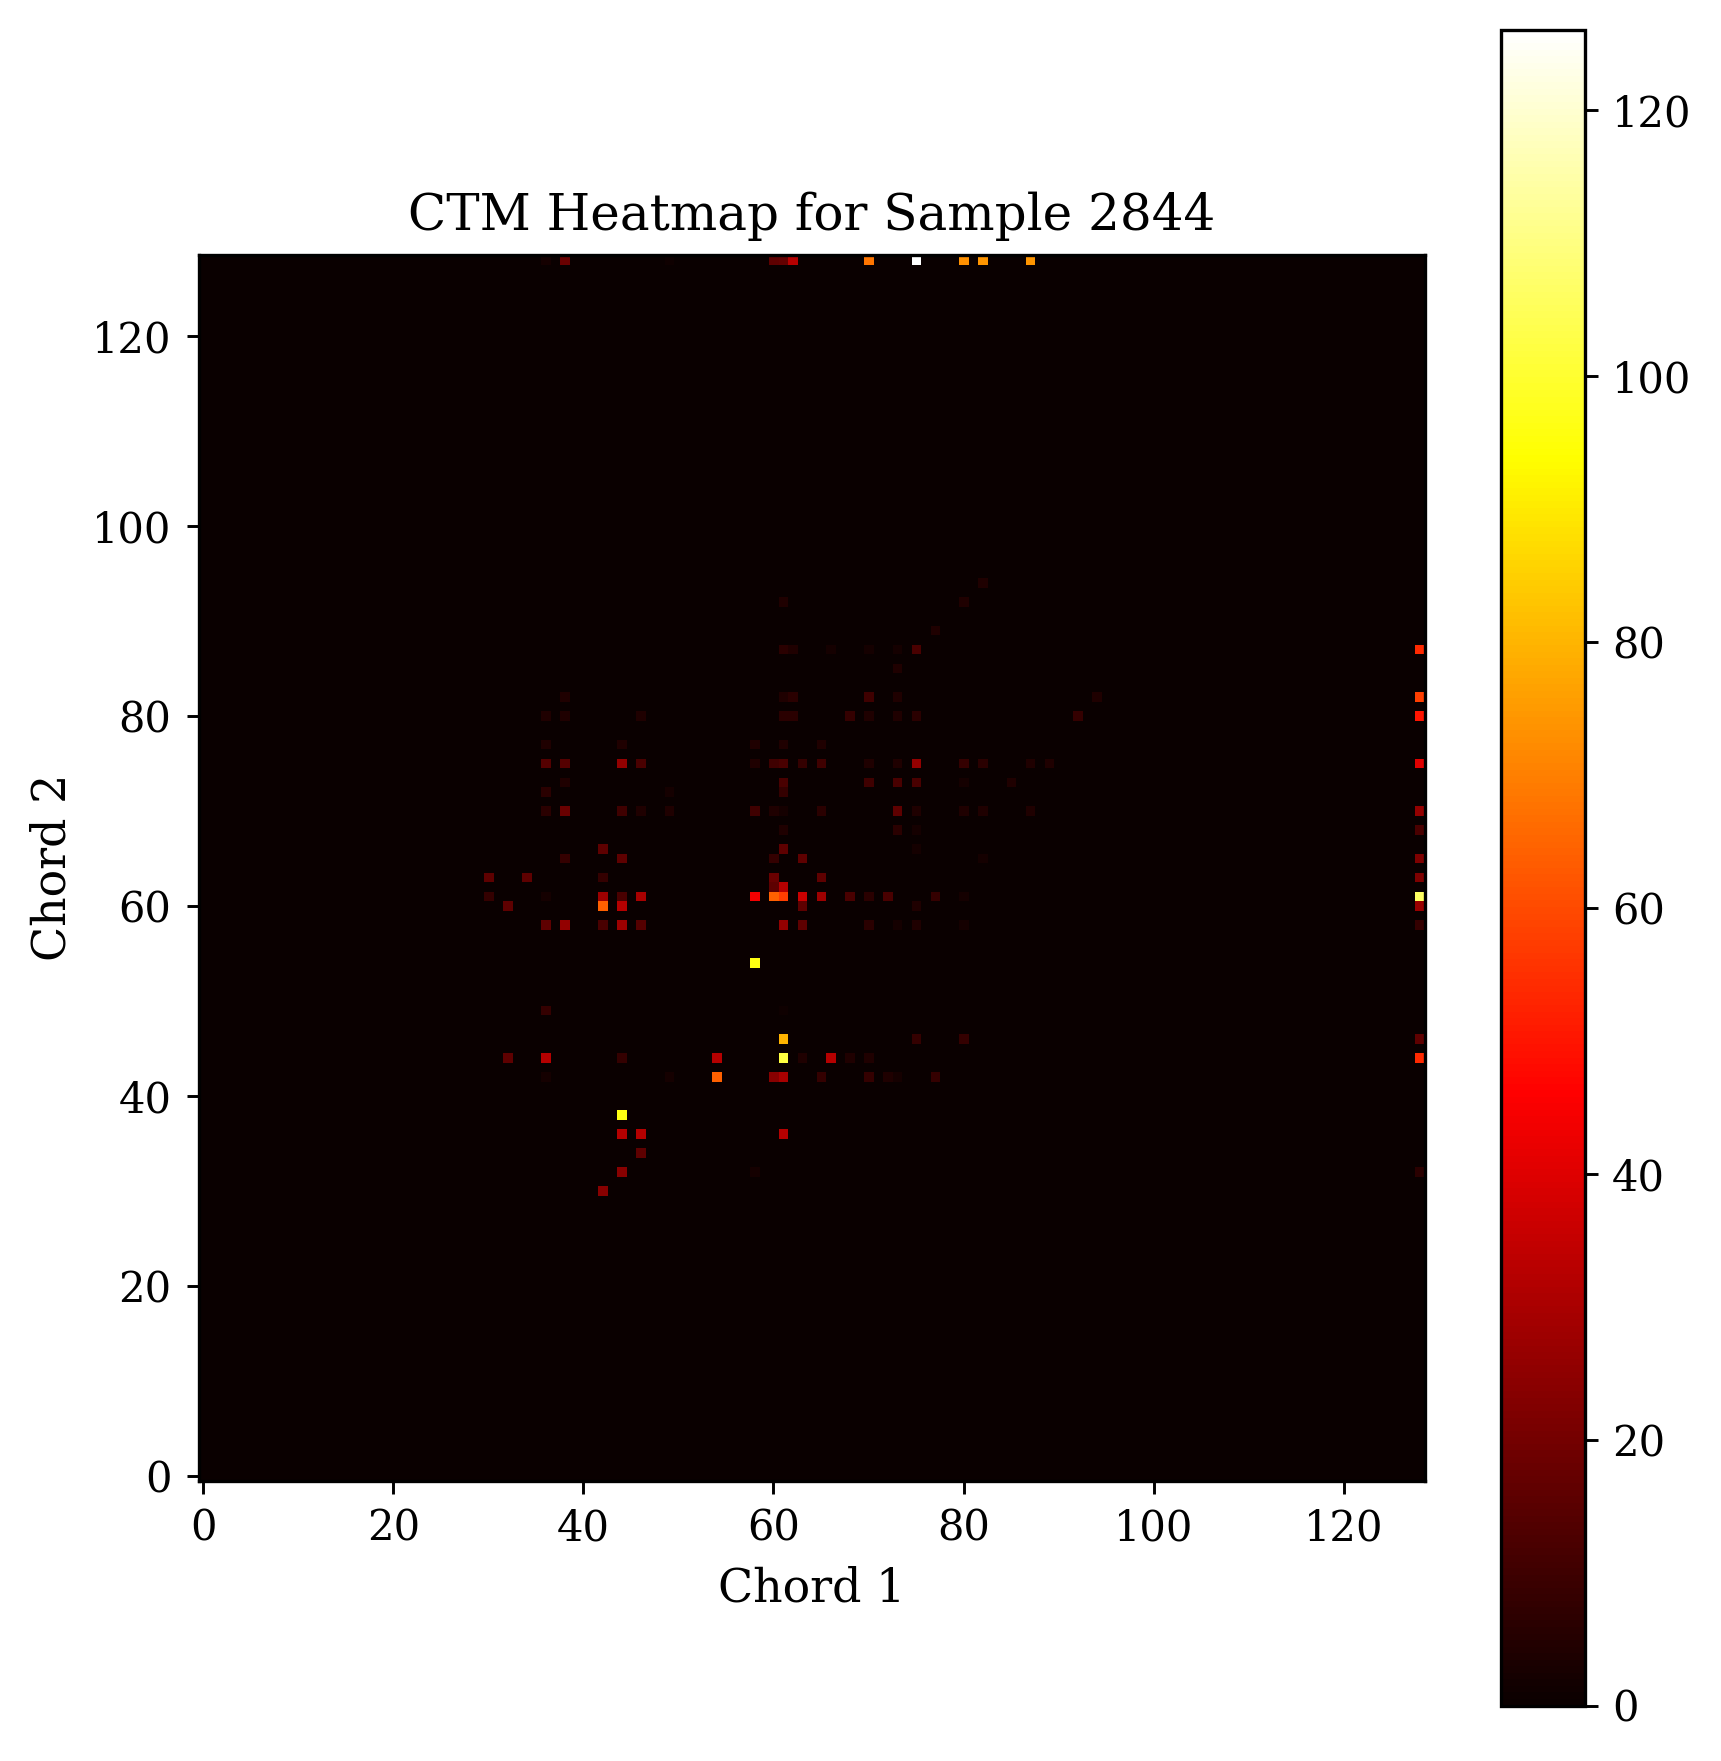

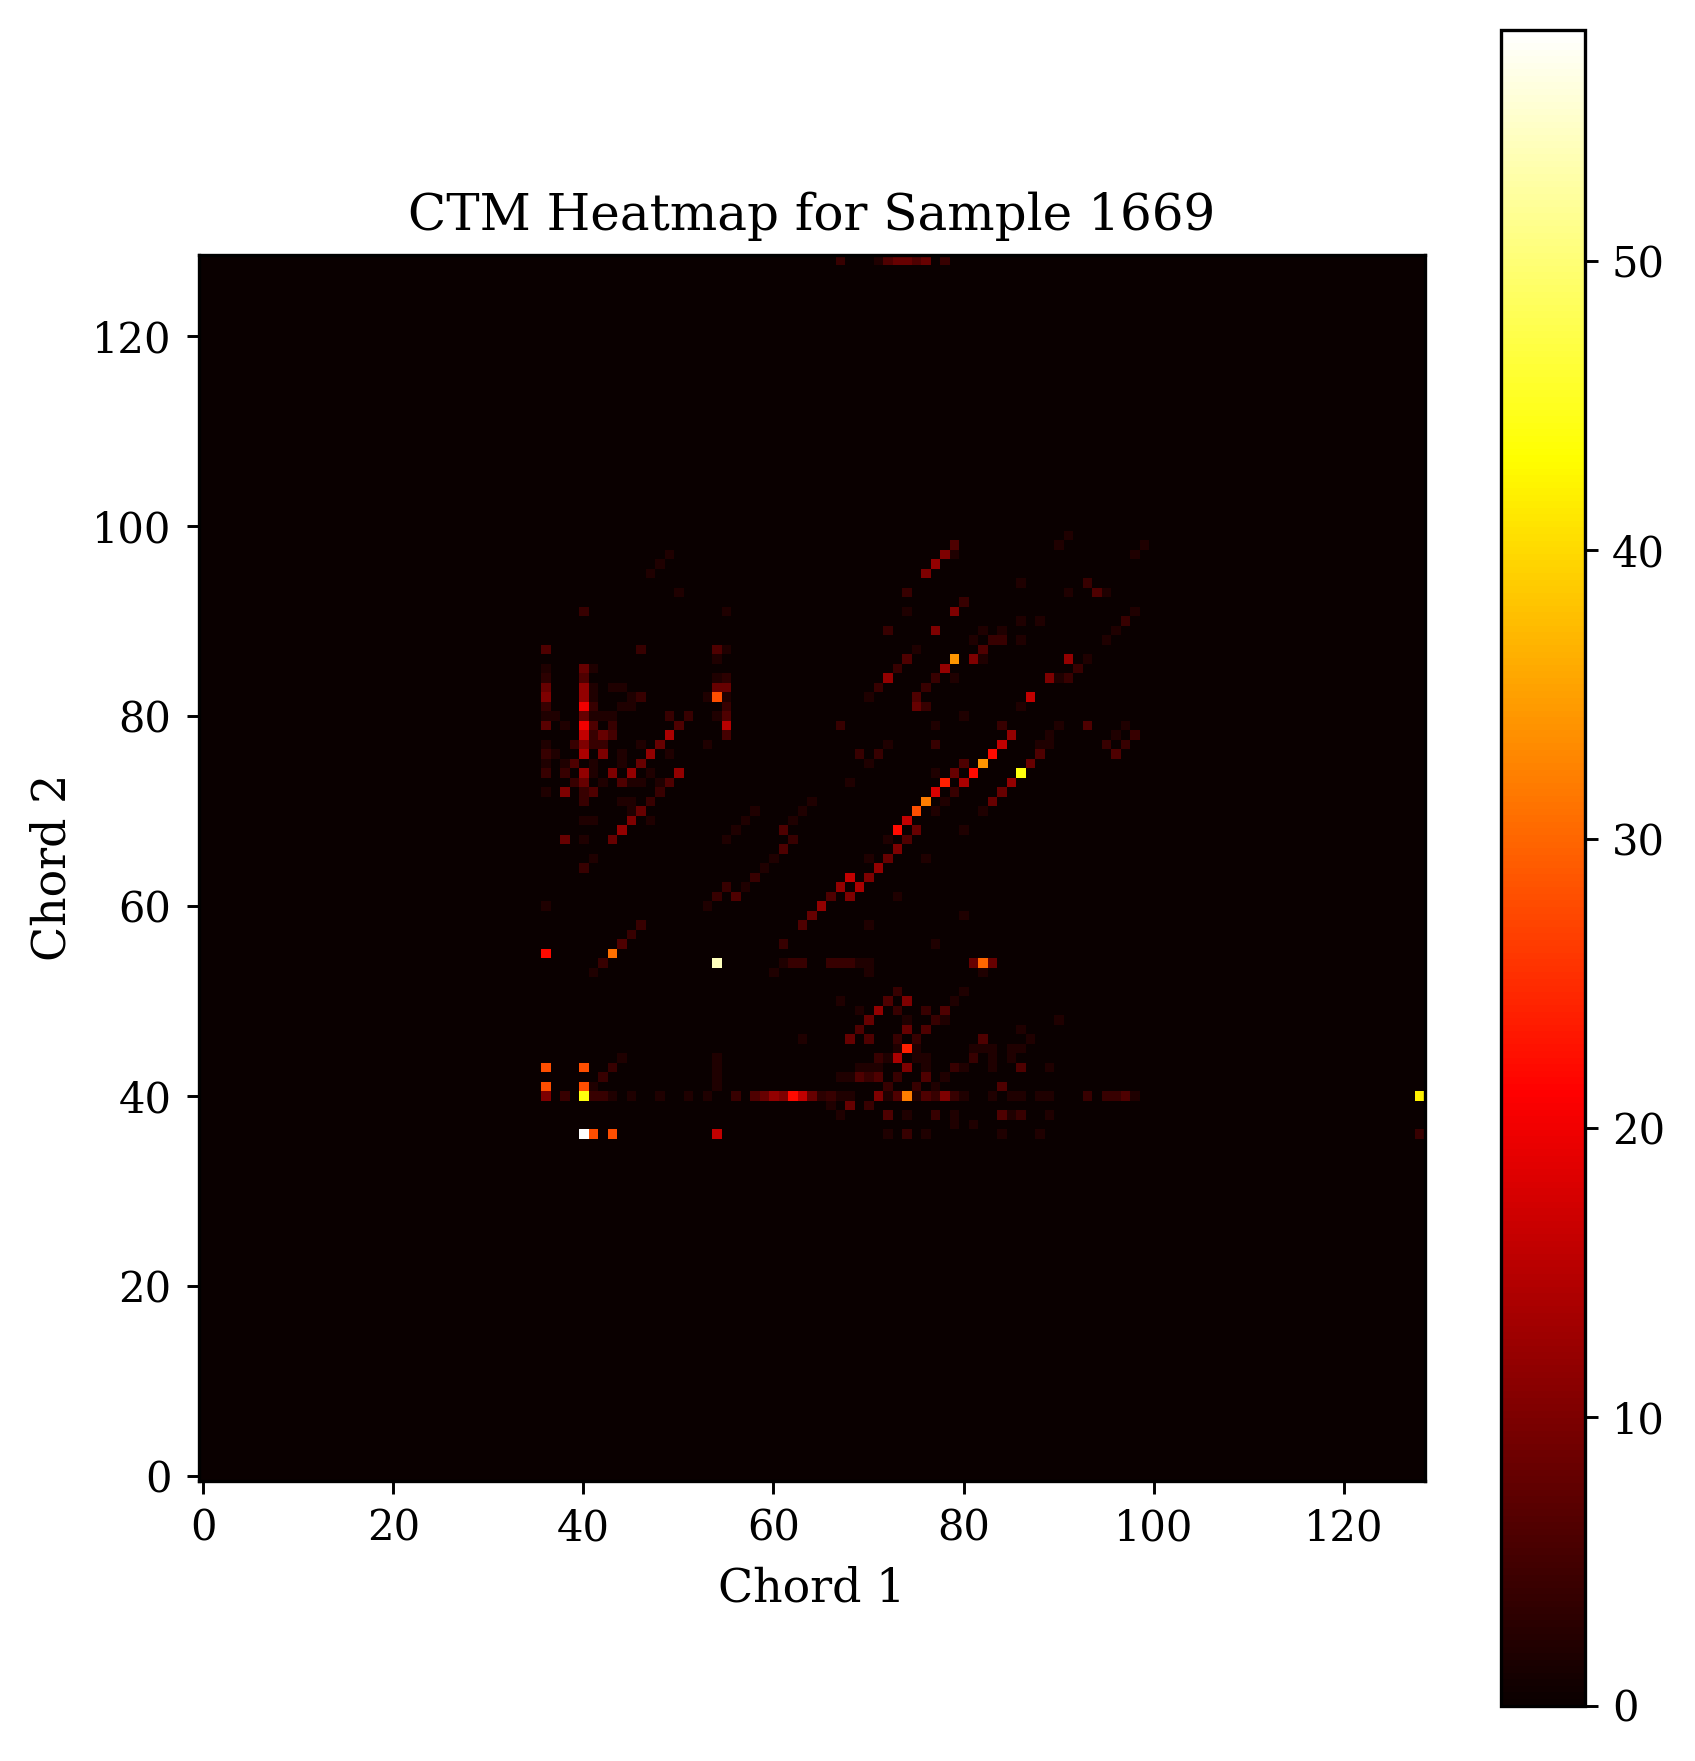

In [7]:
random_indices = np.random.choice(X_ctm.shape[0], size=3, replace=False)
for idx in random_indices:
    plot_ctm_heatmap(X_ctm[idx], title=f"CTM Heatmap for Sample {idx}")

3. PCA explained variance

In [8]:
from typing import List

def plot_pca_explained_var(
    X_list: List[np.ndarray],
    names: List[str],
    save_path: Optional[str] = None
):
    # use tab10 colormap
    colors = plt.get_cmap('tab10').colors
    
    plt.figure(figsize=(6, 4))
    
    for i, (X, name) in enumerate(zip(X_list, names)):
        pca = PCA().fit(X)
        explained_var = pca.explained_variance_ratio_
        cum_explained_var = np.cumsum(explained_var)
        plt.plot(cum_explained_var, label=name, color=colors[i])
        
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.xlim(0, 1000)    
    plt.grid()
    plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

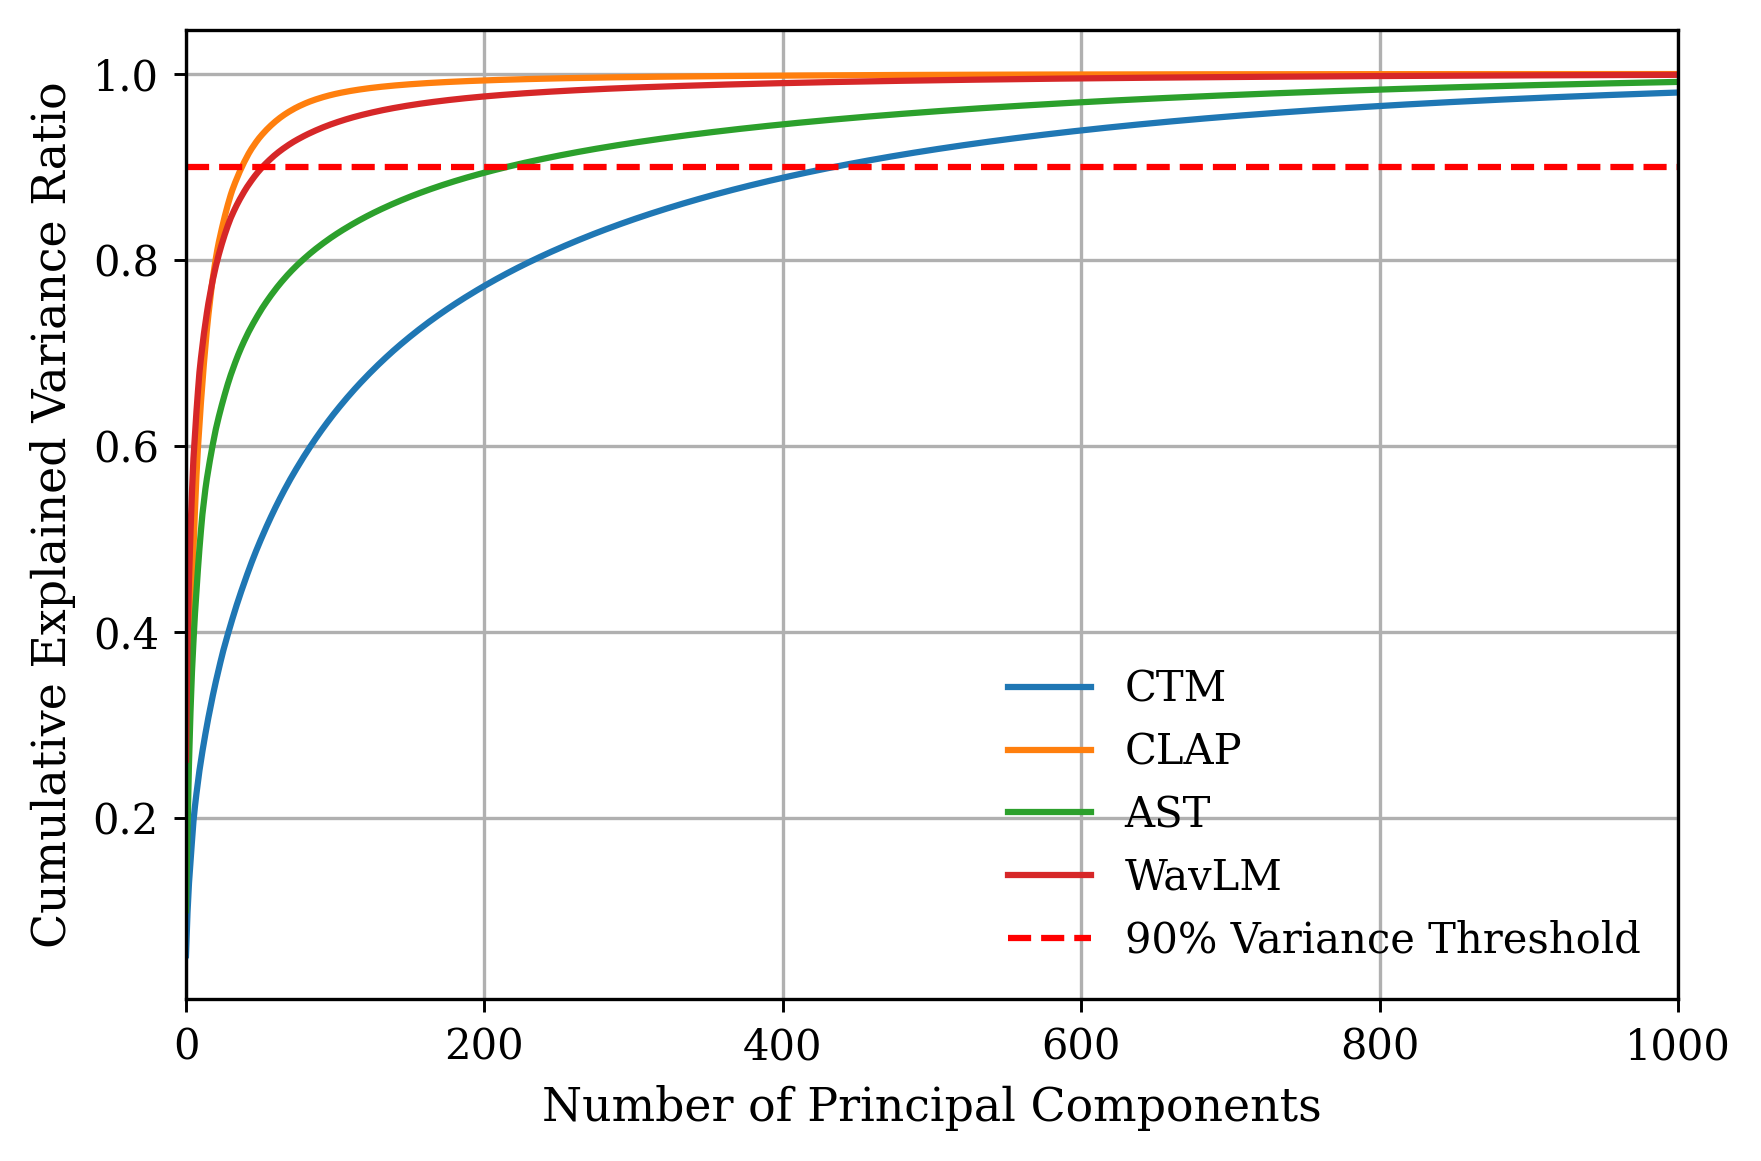

In [9]:
X_list = [X_ctm, X_clap, X_ast, X_wavlm]
names = ['CTM', 'CLAP', 'AST', 'WavLM']
save_path = "results/report_figures/pca_explained_variance.png"
plot_pca_explained_var(X_list, names, save_path=save_path)

4. Distributions of various metadata columns

In [10]:
embeddings_dfs[["name", "rating", "themes", "keywords", "involved_companies", "first_release_year"]].head(5)

,name,rating,themes,keywords,involved_companies,first_release_year
0,Star Wars: Rogue Squadron II - Rogue Leader,85.4,"[""Action"", ""Science fiction""]","[""space simulation"", ""space combat"", ""robots"",...","[""Activision"", ""Factor 5"", ""LucasArts""]",2001
1,Star Wars: Rogue Squadron II - Rogue Leader,85.4,"[""Action"", ""Science fiction""]","[""space simulation"", ""space combat"", ""robots"",...","[""Activision"", ""Factor 5"", ""LucasArts""]",2001
2,Donkey Kong Jungle Beat,67.7,"[""Action""]","[""combat"", ""pig"", ""panda"", ""underwater gamepla...","[""Nintendo EAD Tokyo Software Development Grou...",2004
3,Donkey Kong Jungle Beat,67.7,"[""Action""]","[""combat"", ""pig"", ""panda"", ""underwater gamepla...","[""Nintendo EAD Tokyo Software Development Grou...",2004
4,Viewtiful Joe,0,"[""Action""]",[],"[""Clover Studio"", ""Capcom""]",2004


In [19]:
import ast
from collections import Counter

def plot_global_metadata_eda(df, columns, top_n=15, save_dir=None, model_name=None):
    """
    Plot global metadata distributions for specified list-like columns
    using the SAME flattening logic as `column_wise_summary`.

    Parameters
    ----------
    df : pd.DataFrame
        Raw dataset dataframe (NO cluster labels required).
    columns : list of str
        Columns to summarize (must match names in df).
    top_n : int
        Number of top categories to display.
    """

    def flatten_values(series):
        """Apply the exact same flattening logic used in column_wise_summary."""
        flat = []
        for item in series.dropna():
            # Case 1: actual list
            if isinstance(item, list):
                flat.extend(item)
                continue

            # Case 2: string that *might* represent a list
            if isinstance(item, str):
                s = item.strip()
                parsed = None

                # Try to parse stringified list via literal_eval
                if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
                    try:
                        parsed = ast.literal_eval(s)
                    except Exception:
                        parsed = None

                if isinstance(parsed, list):
                    flat.extend(parsed)
                else:
                    flat.append(item)  # plain string
                continue

            # Case 3: scalar value (number, etc.)
            flat.append(item)

        return flat

    # ---- Process each column globally ----
    for col in columns:
        if col not in df.columns:
            print(f"Column '{col}' not found, skipping.")
            continue

        print(f"\n=== Global distribution for '{col}' ===")

        flat_values = flatten_values(df[col])
        if not flat_values:
            print(f"No data for '{col}', skipping.")
            continue

        counts = Counter(flat_values)
        top_items = counts.most_common(top_n)
        labels, values = zip(*top_items)

        # Plot
        plt.figure(figsize=(8, 6))
        plt.barh(labels, values, color="gray", alpha=0.8)
        plt.gca().invert_yaxis()
        plt.title(f"Global Distribution: {col}", fontweight="bold")
        plt.xlabel("Count")
        plt.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"global_distribution_{col}.png")
            plt.savefig(save_path, dpi=300)
        plt.show()



=== Global distribution for 'name' ===


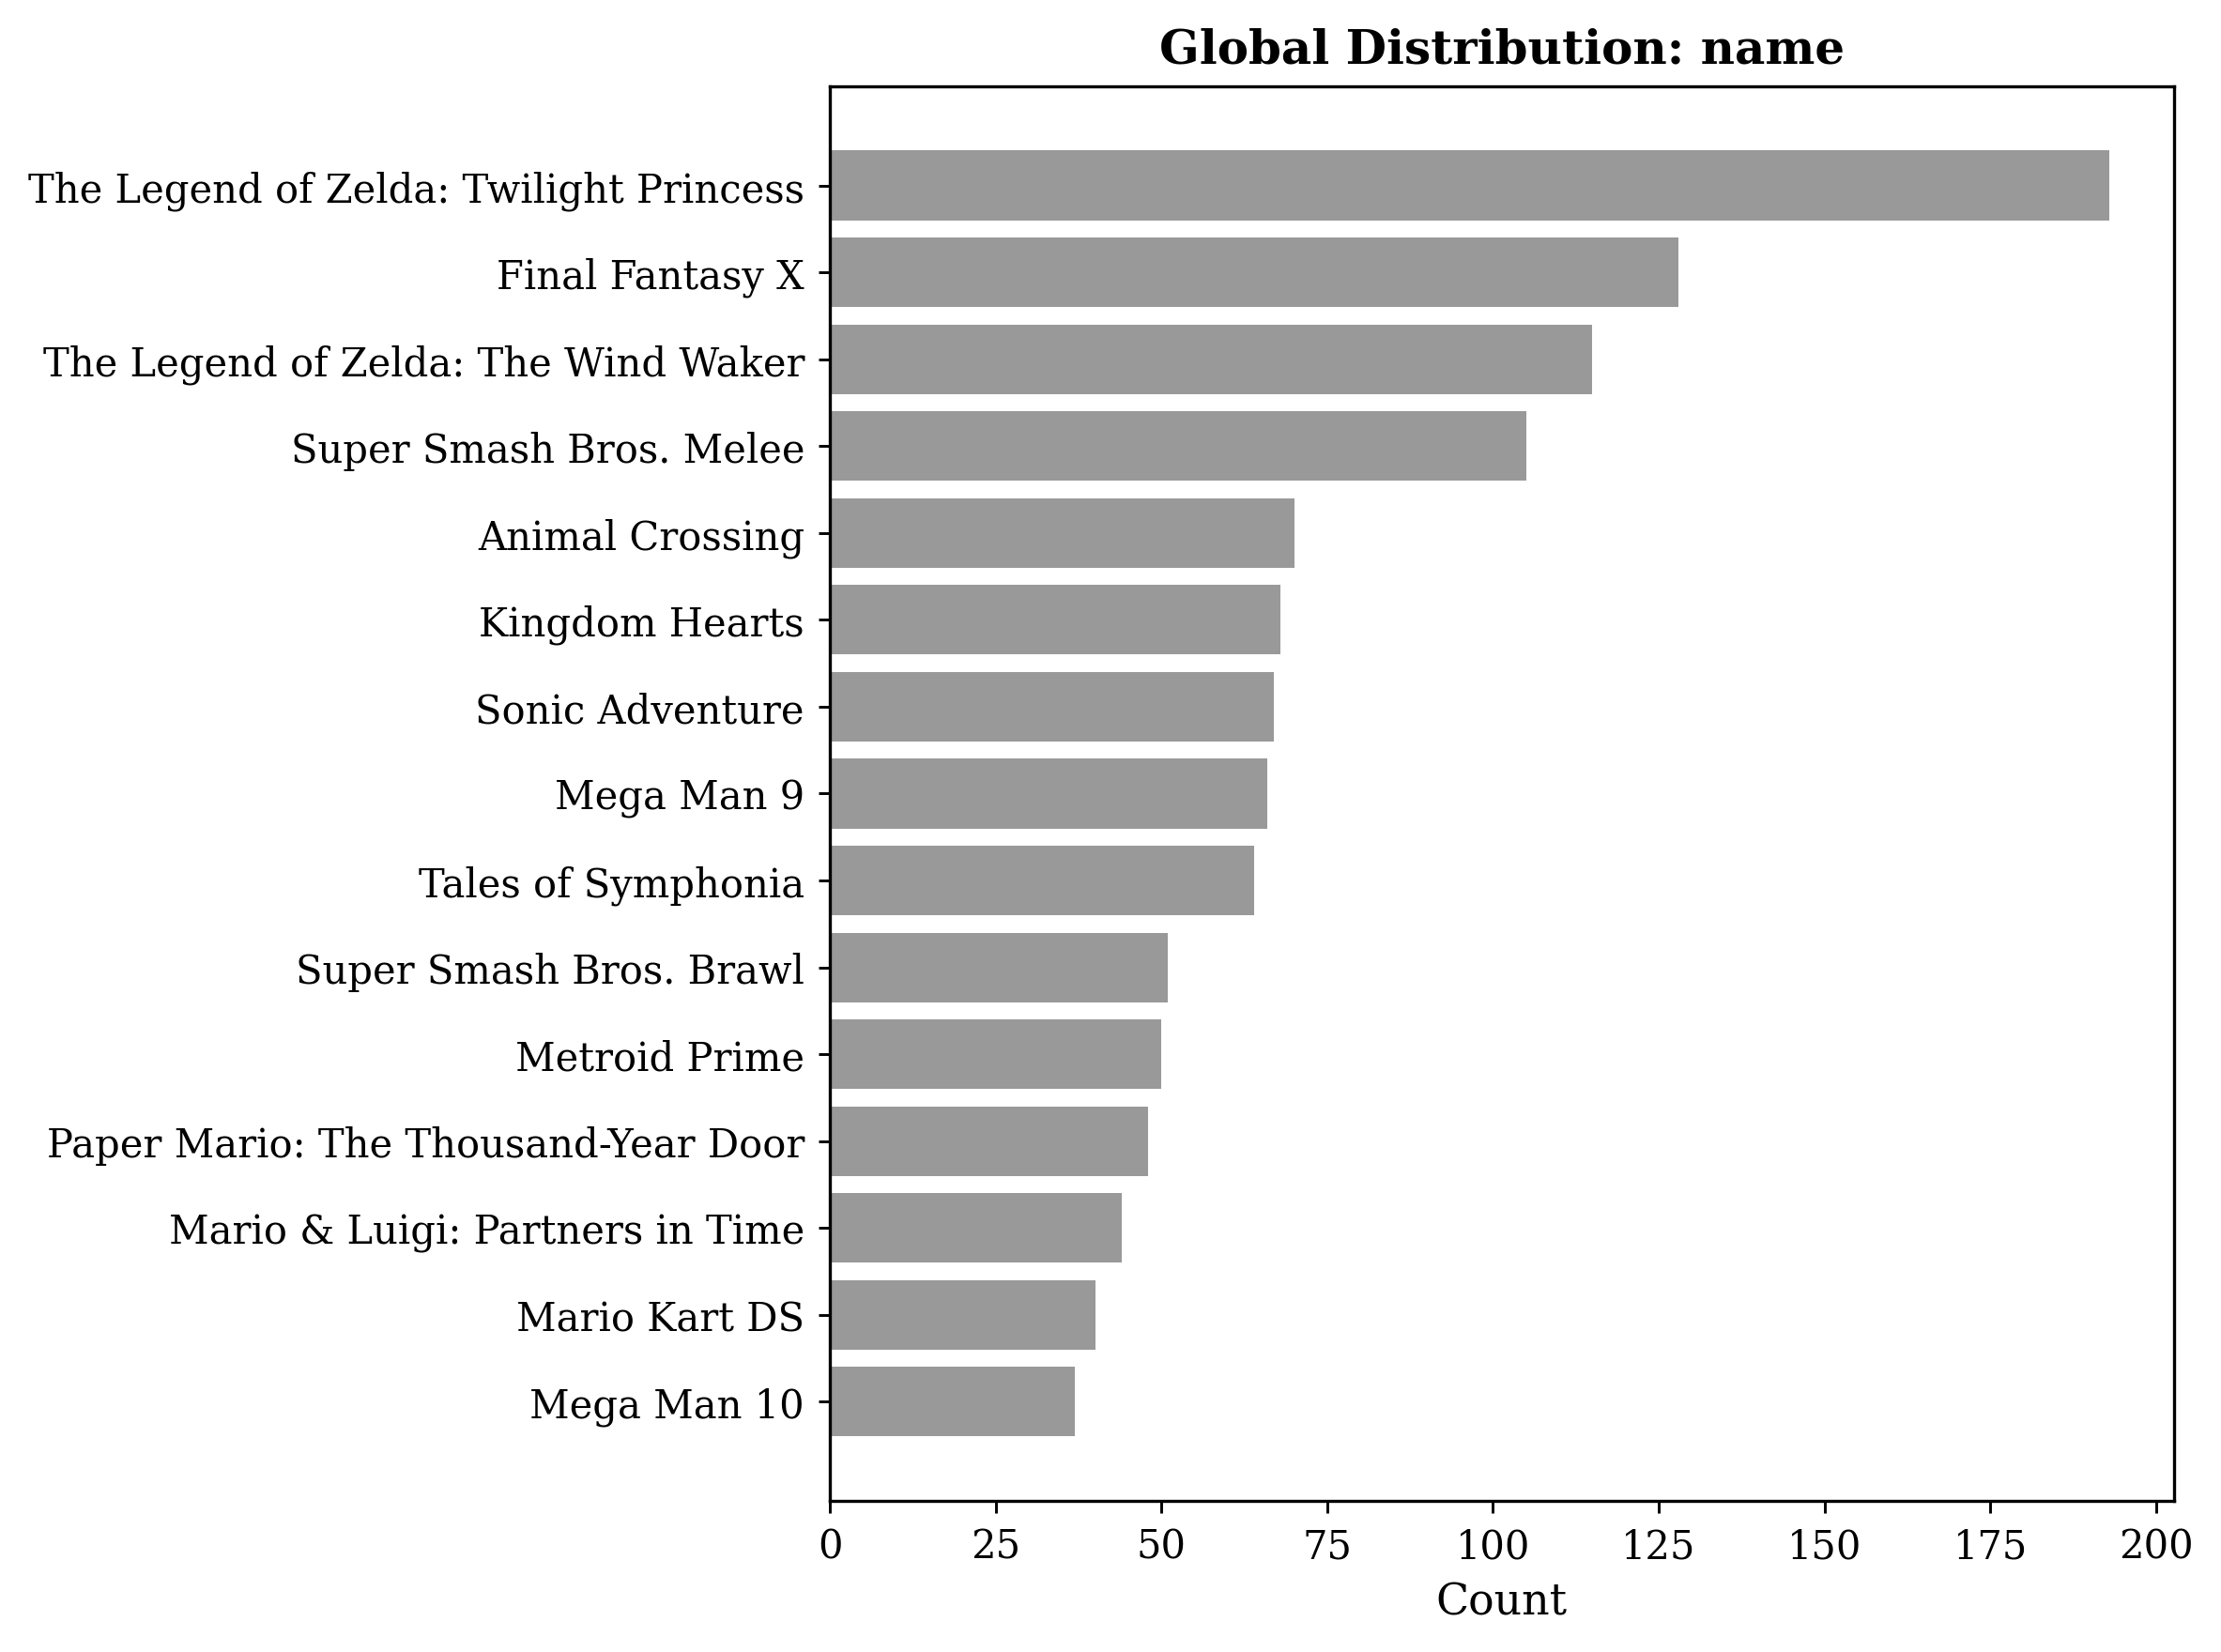


=== Global distribution for 'rating' ===


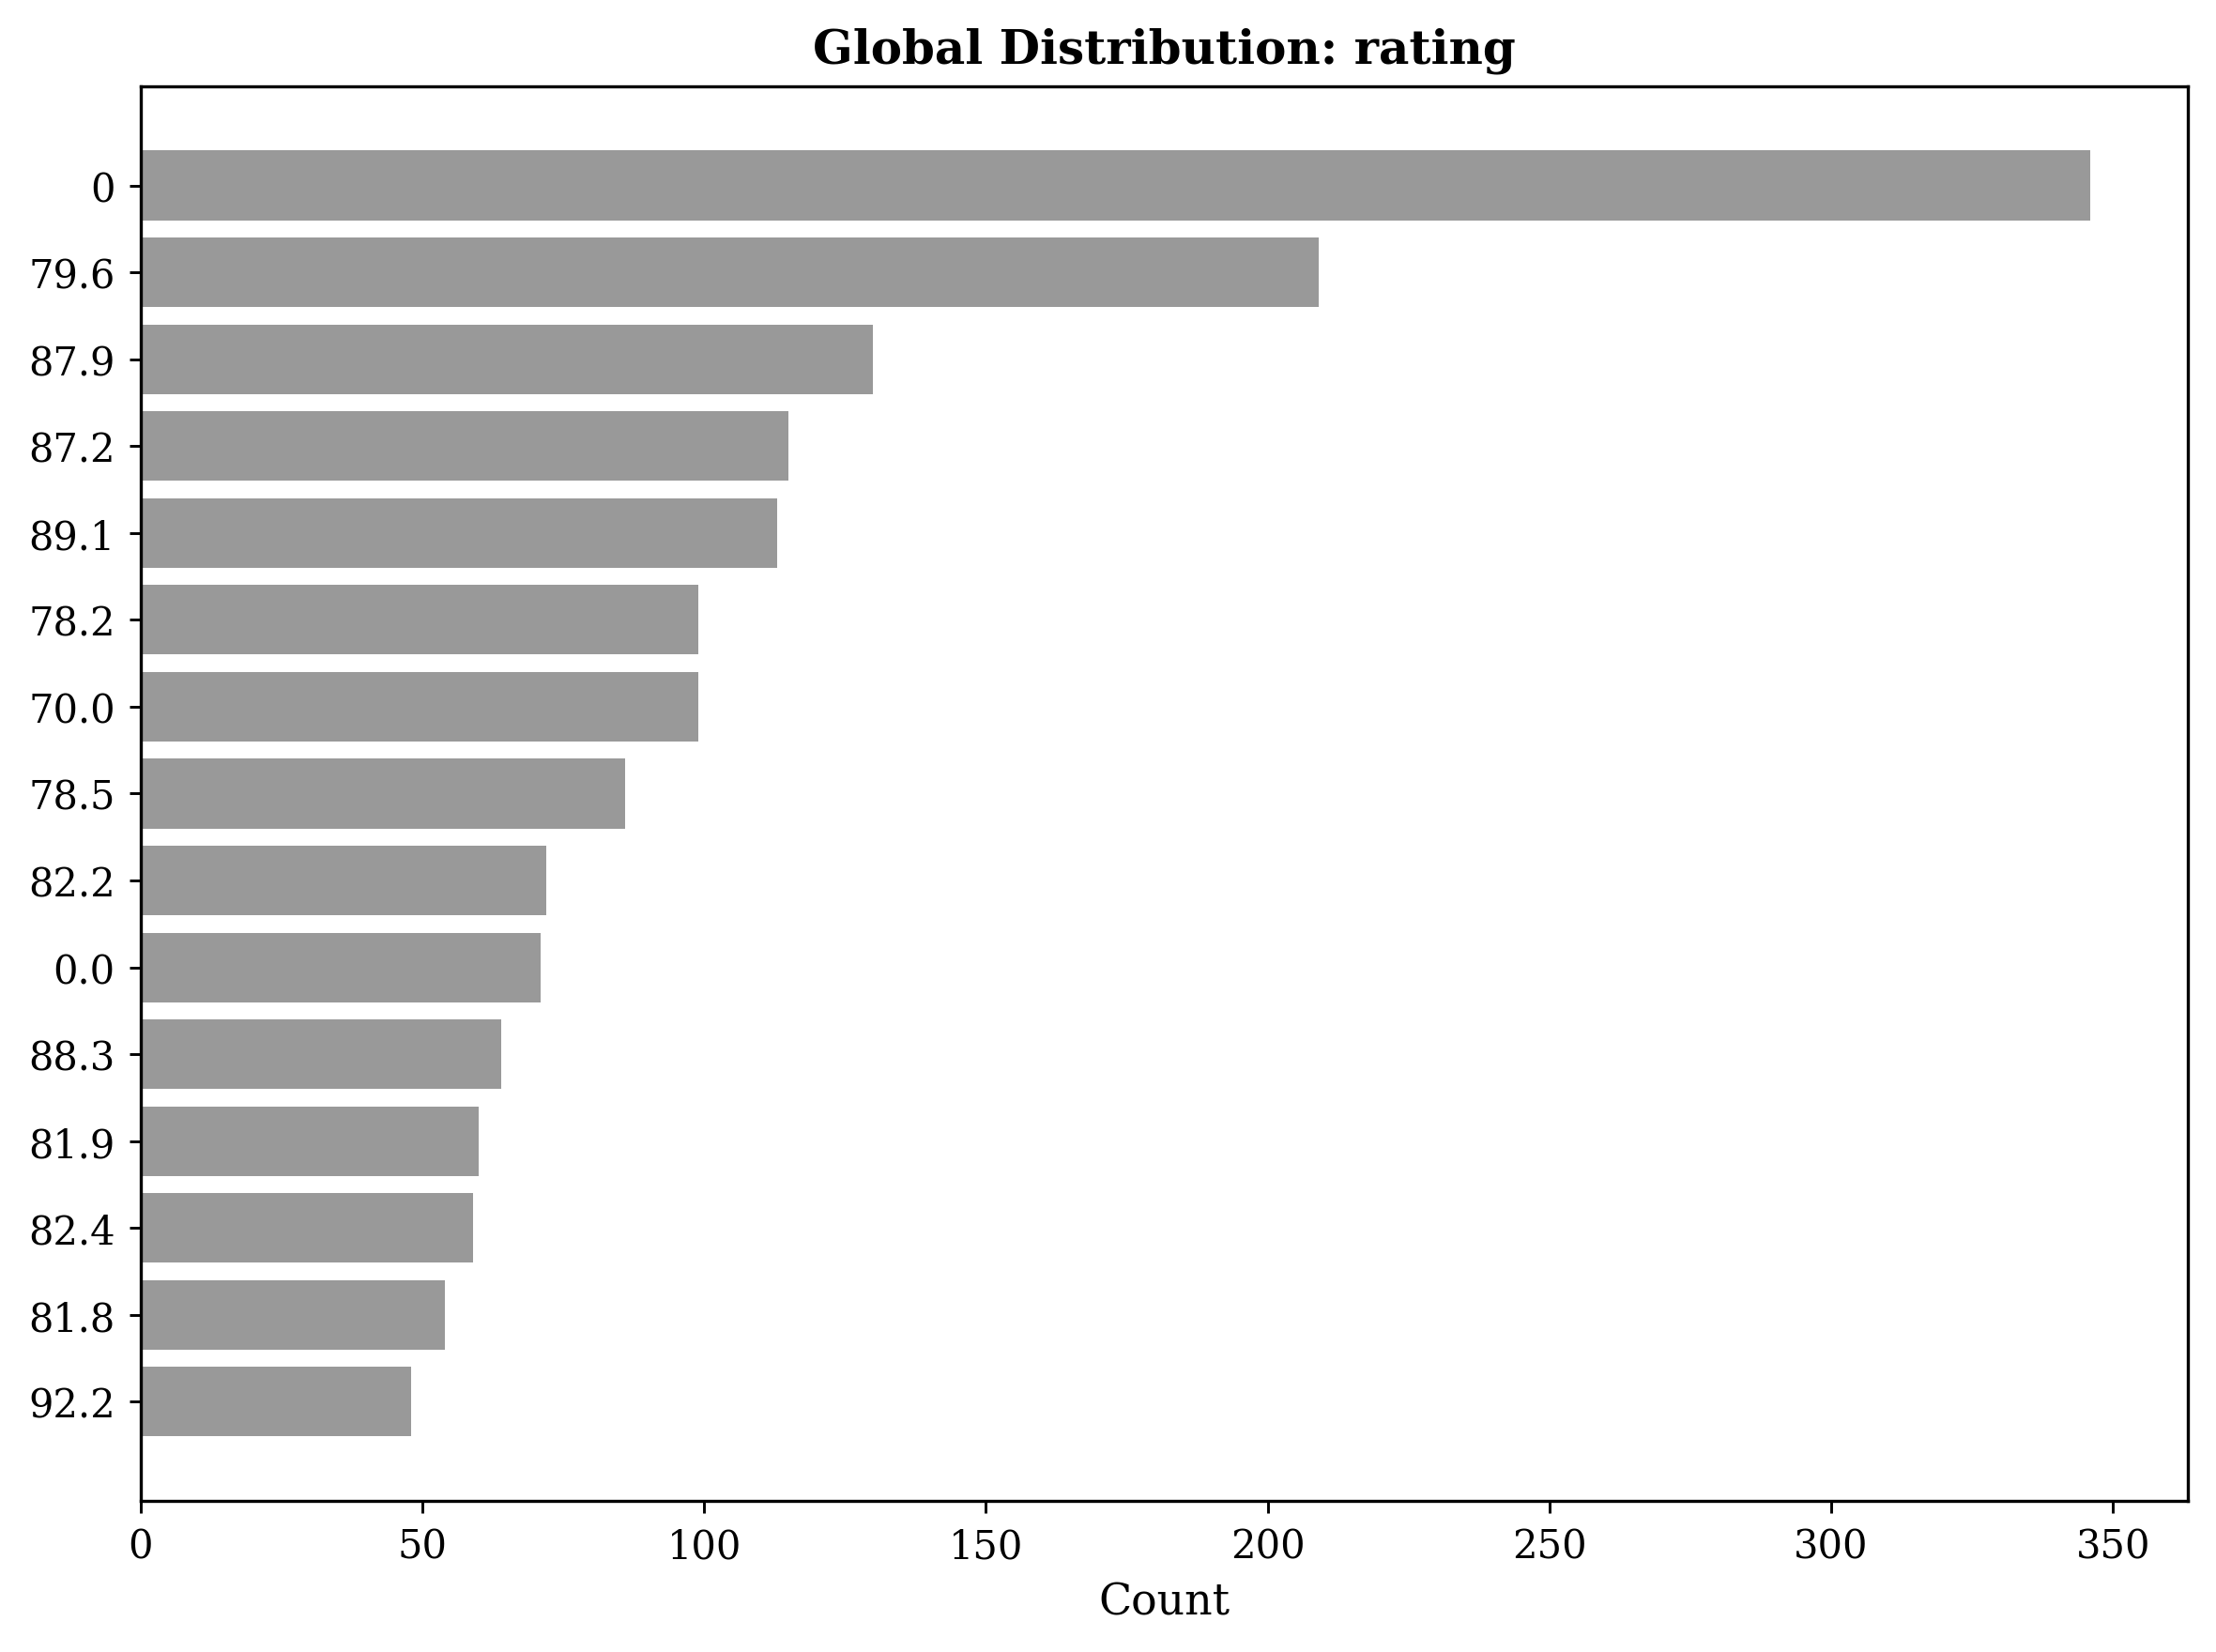


=== Global distribution for 'themes' ===


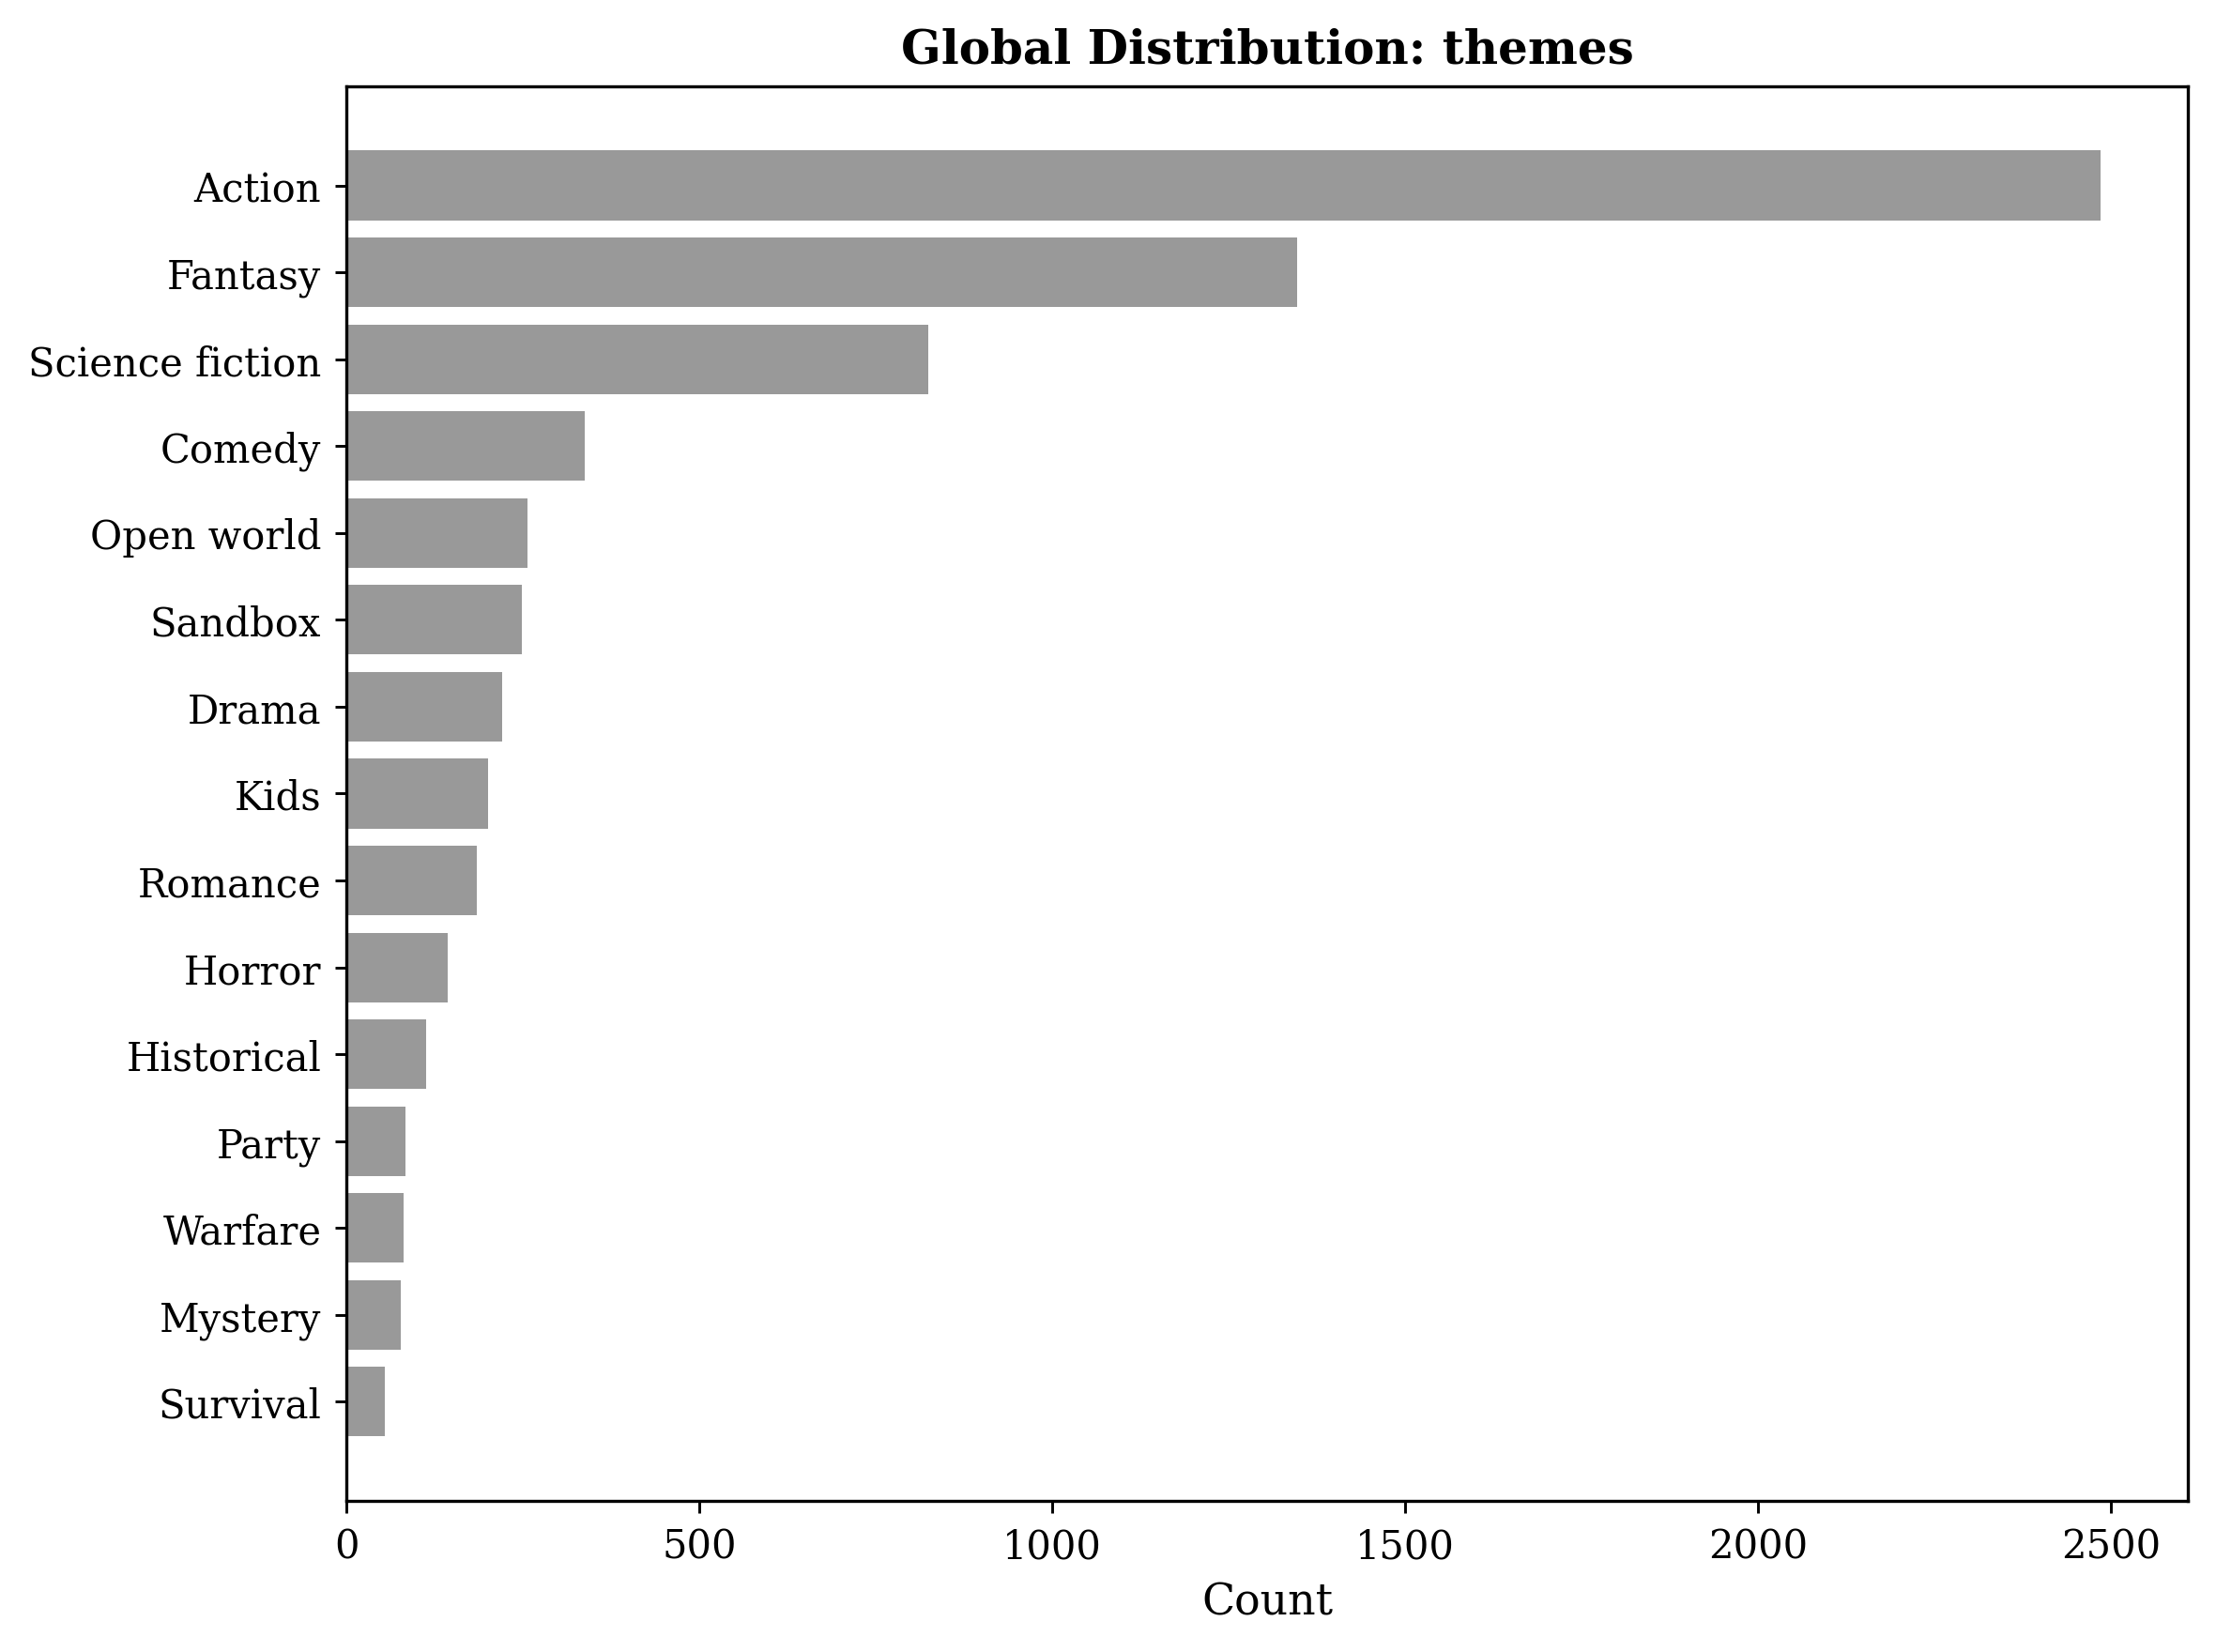


=== Global distribution for 'keywords' ===


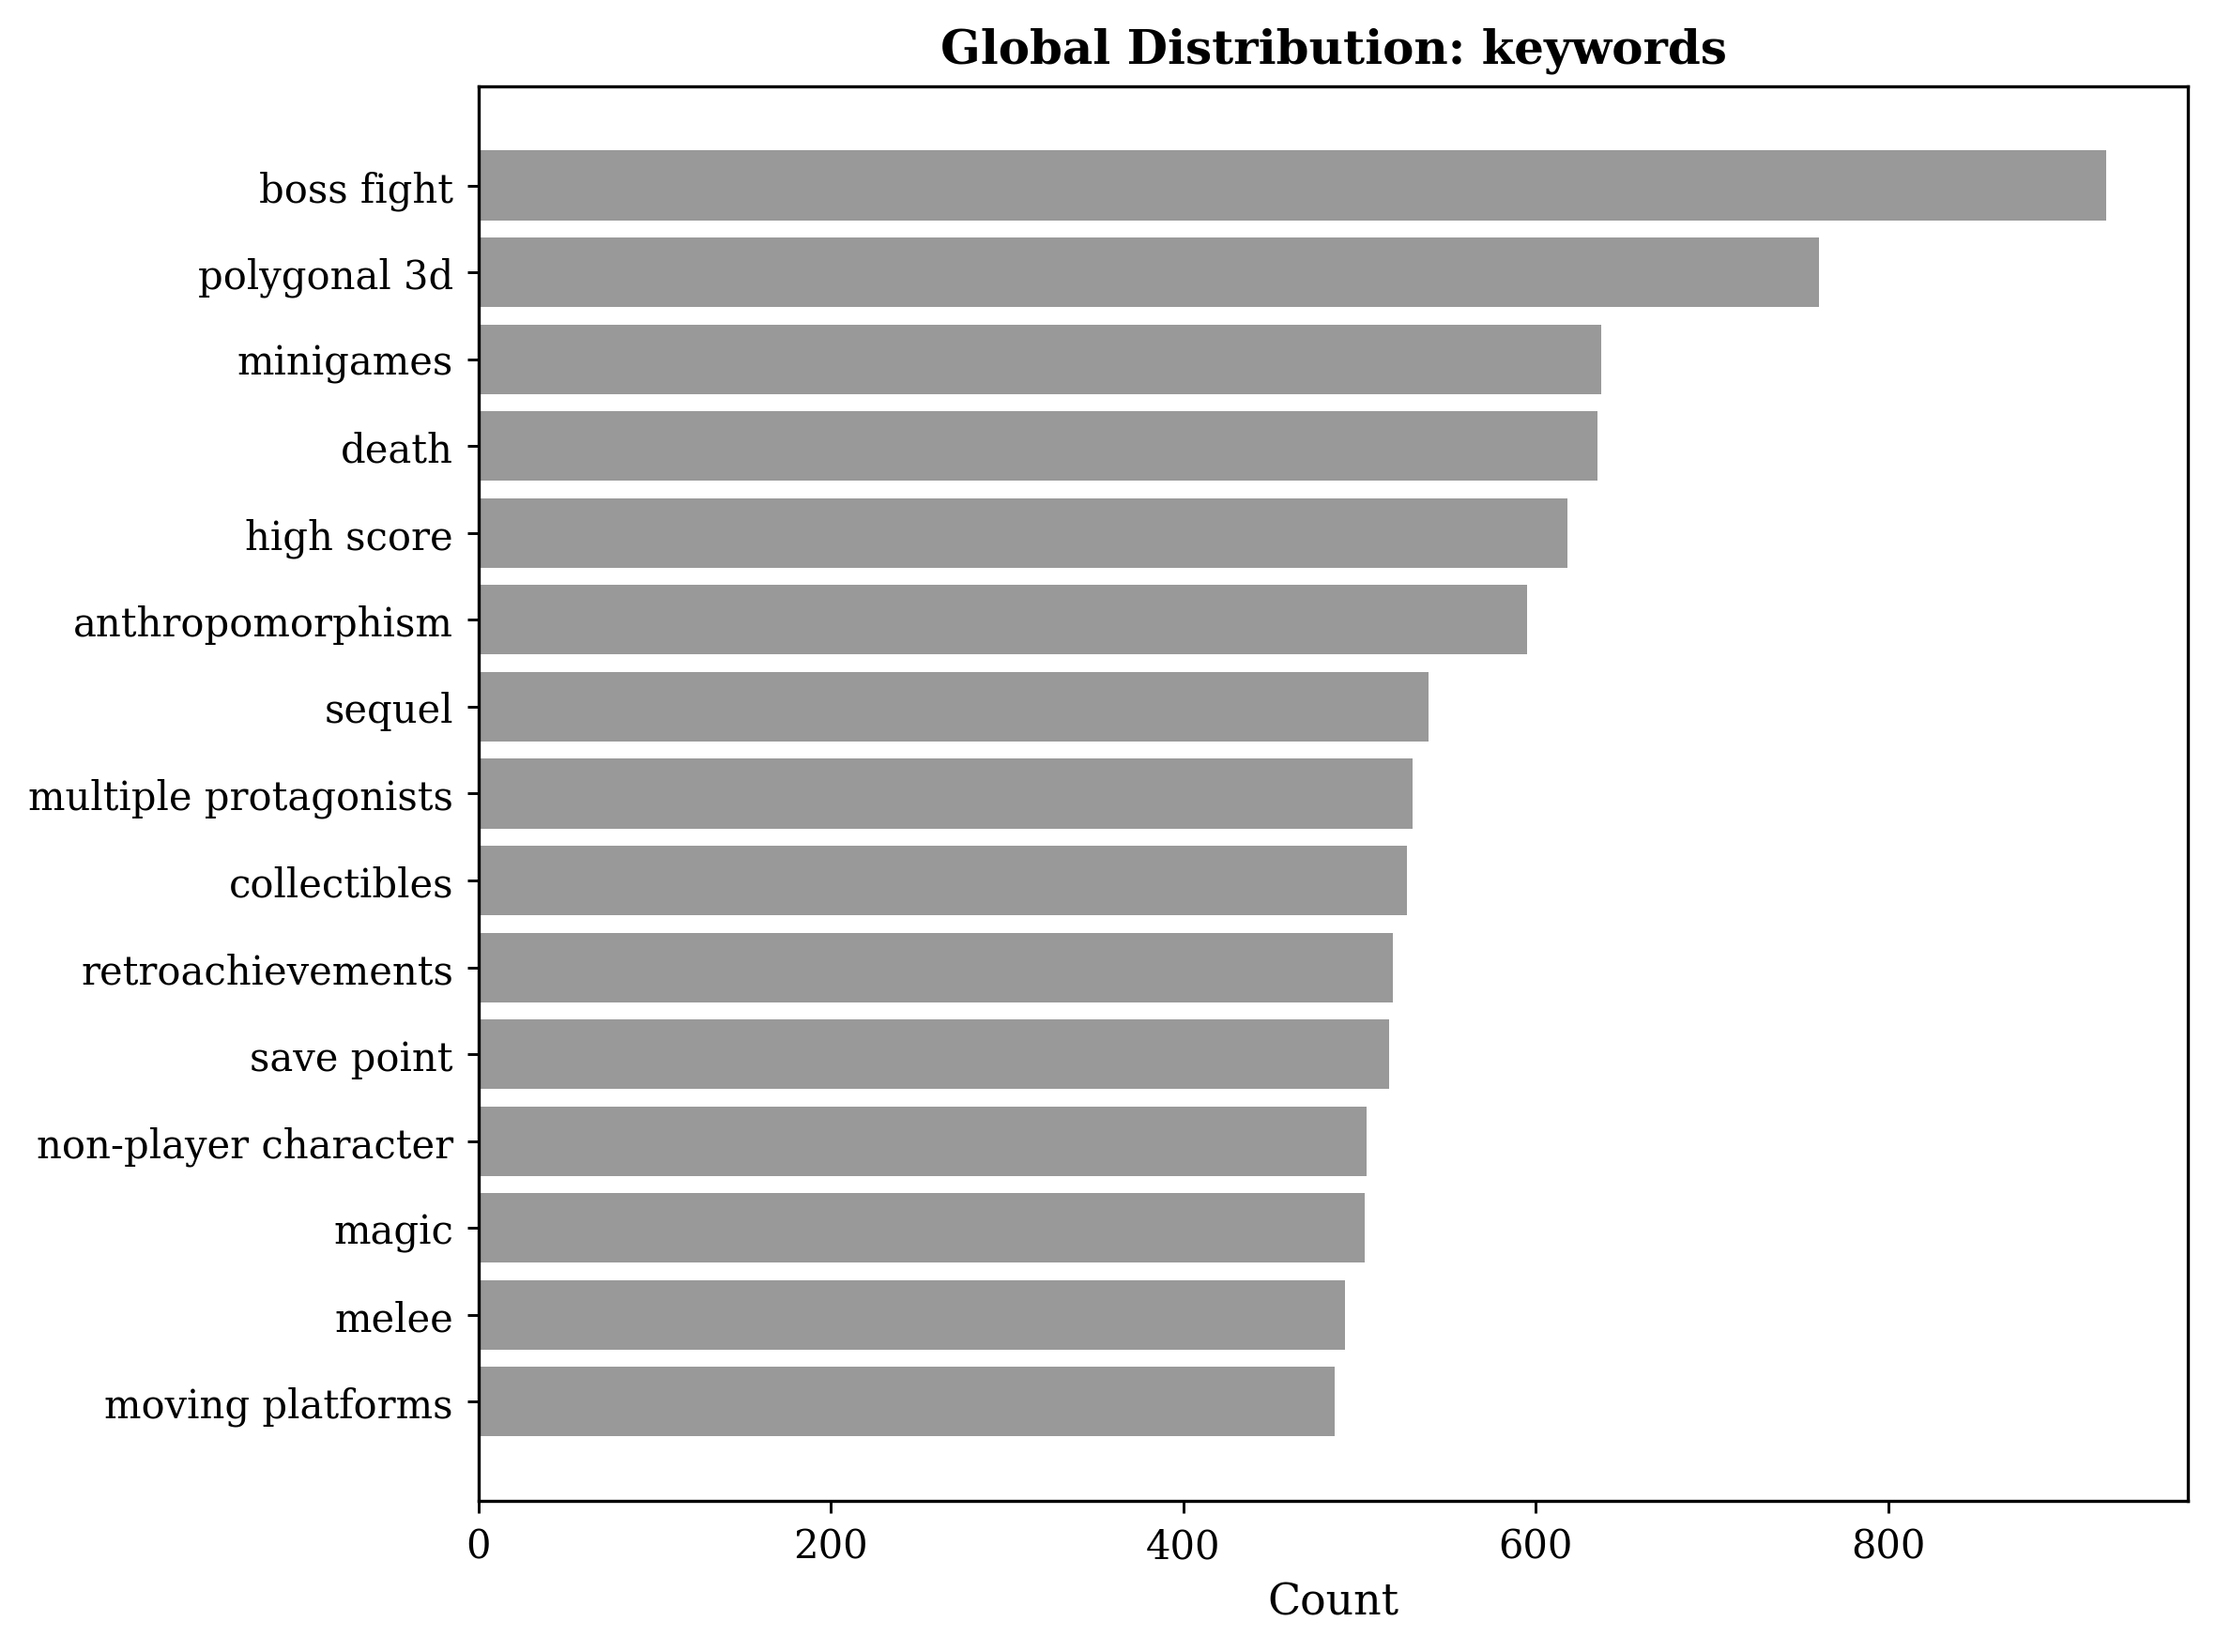


=== Global distribution for 'involved_companies' ===


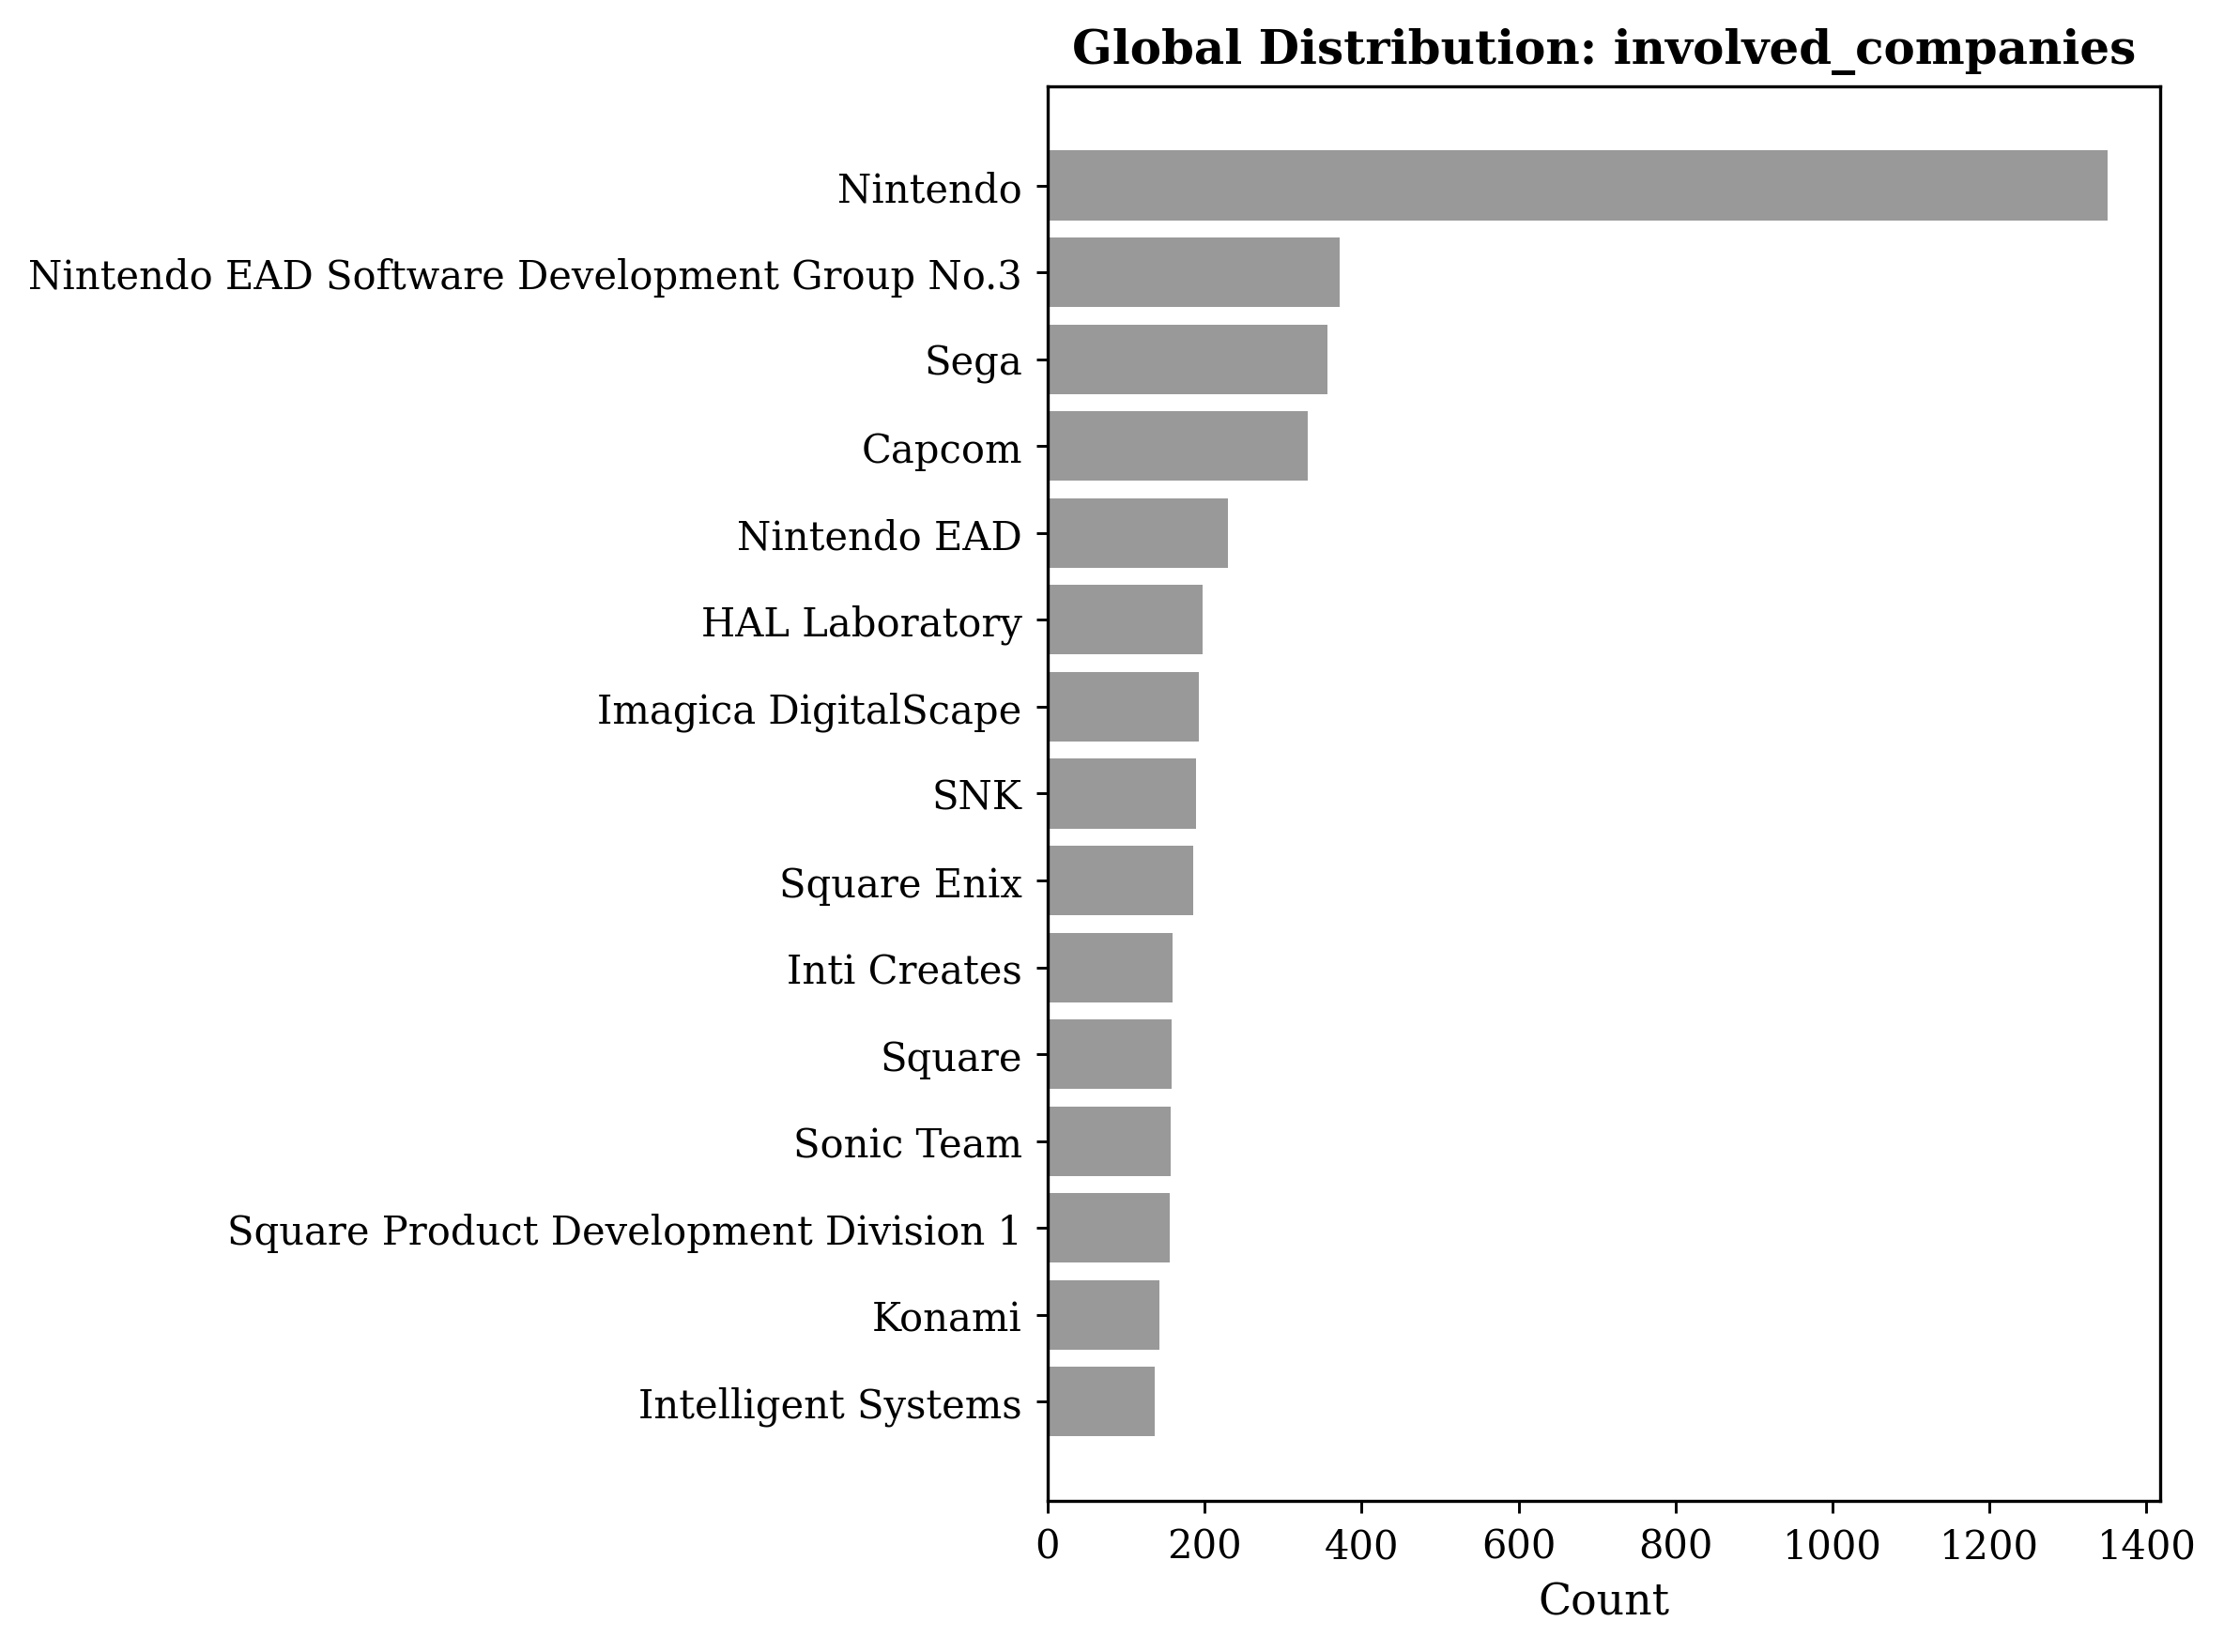


=== Global distribution for 'first_release_year' ===


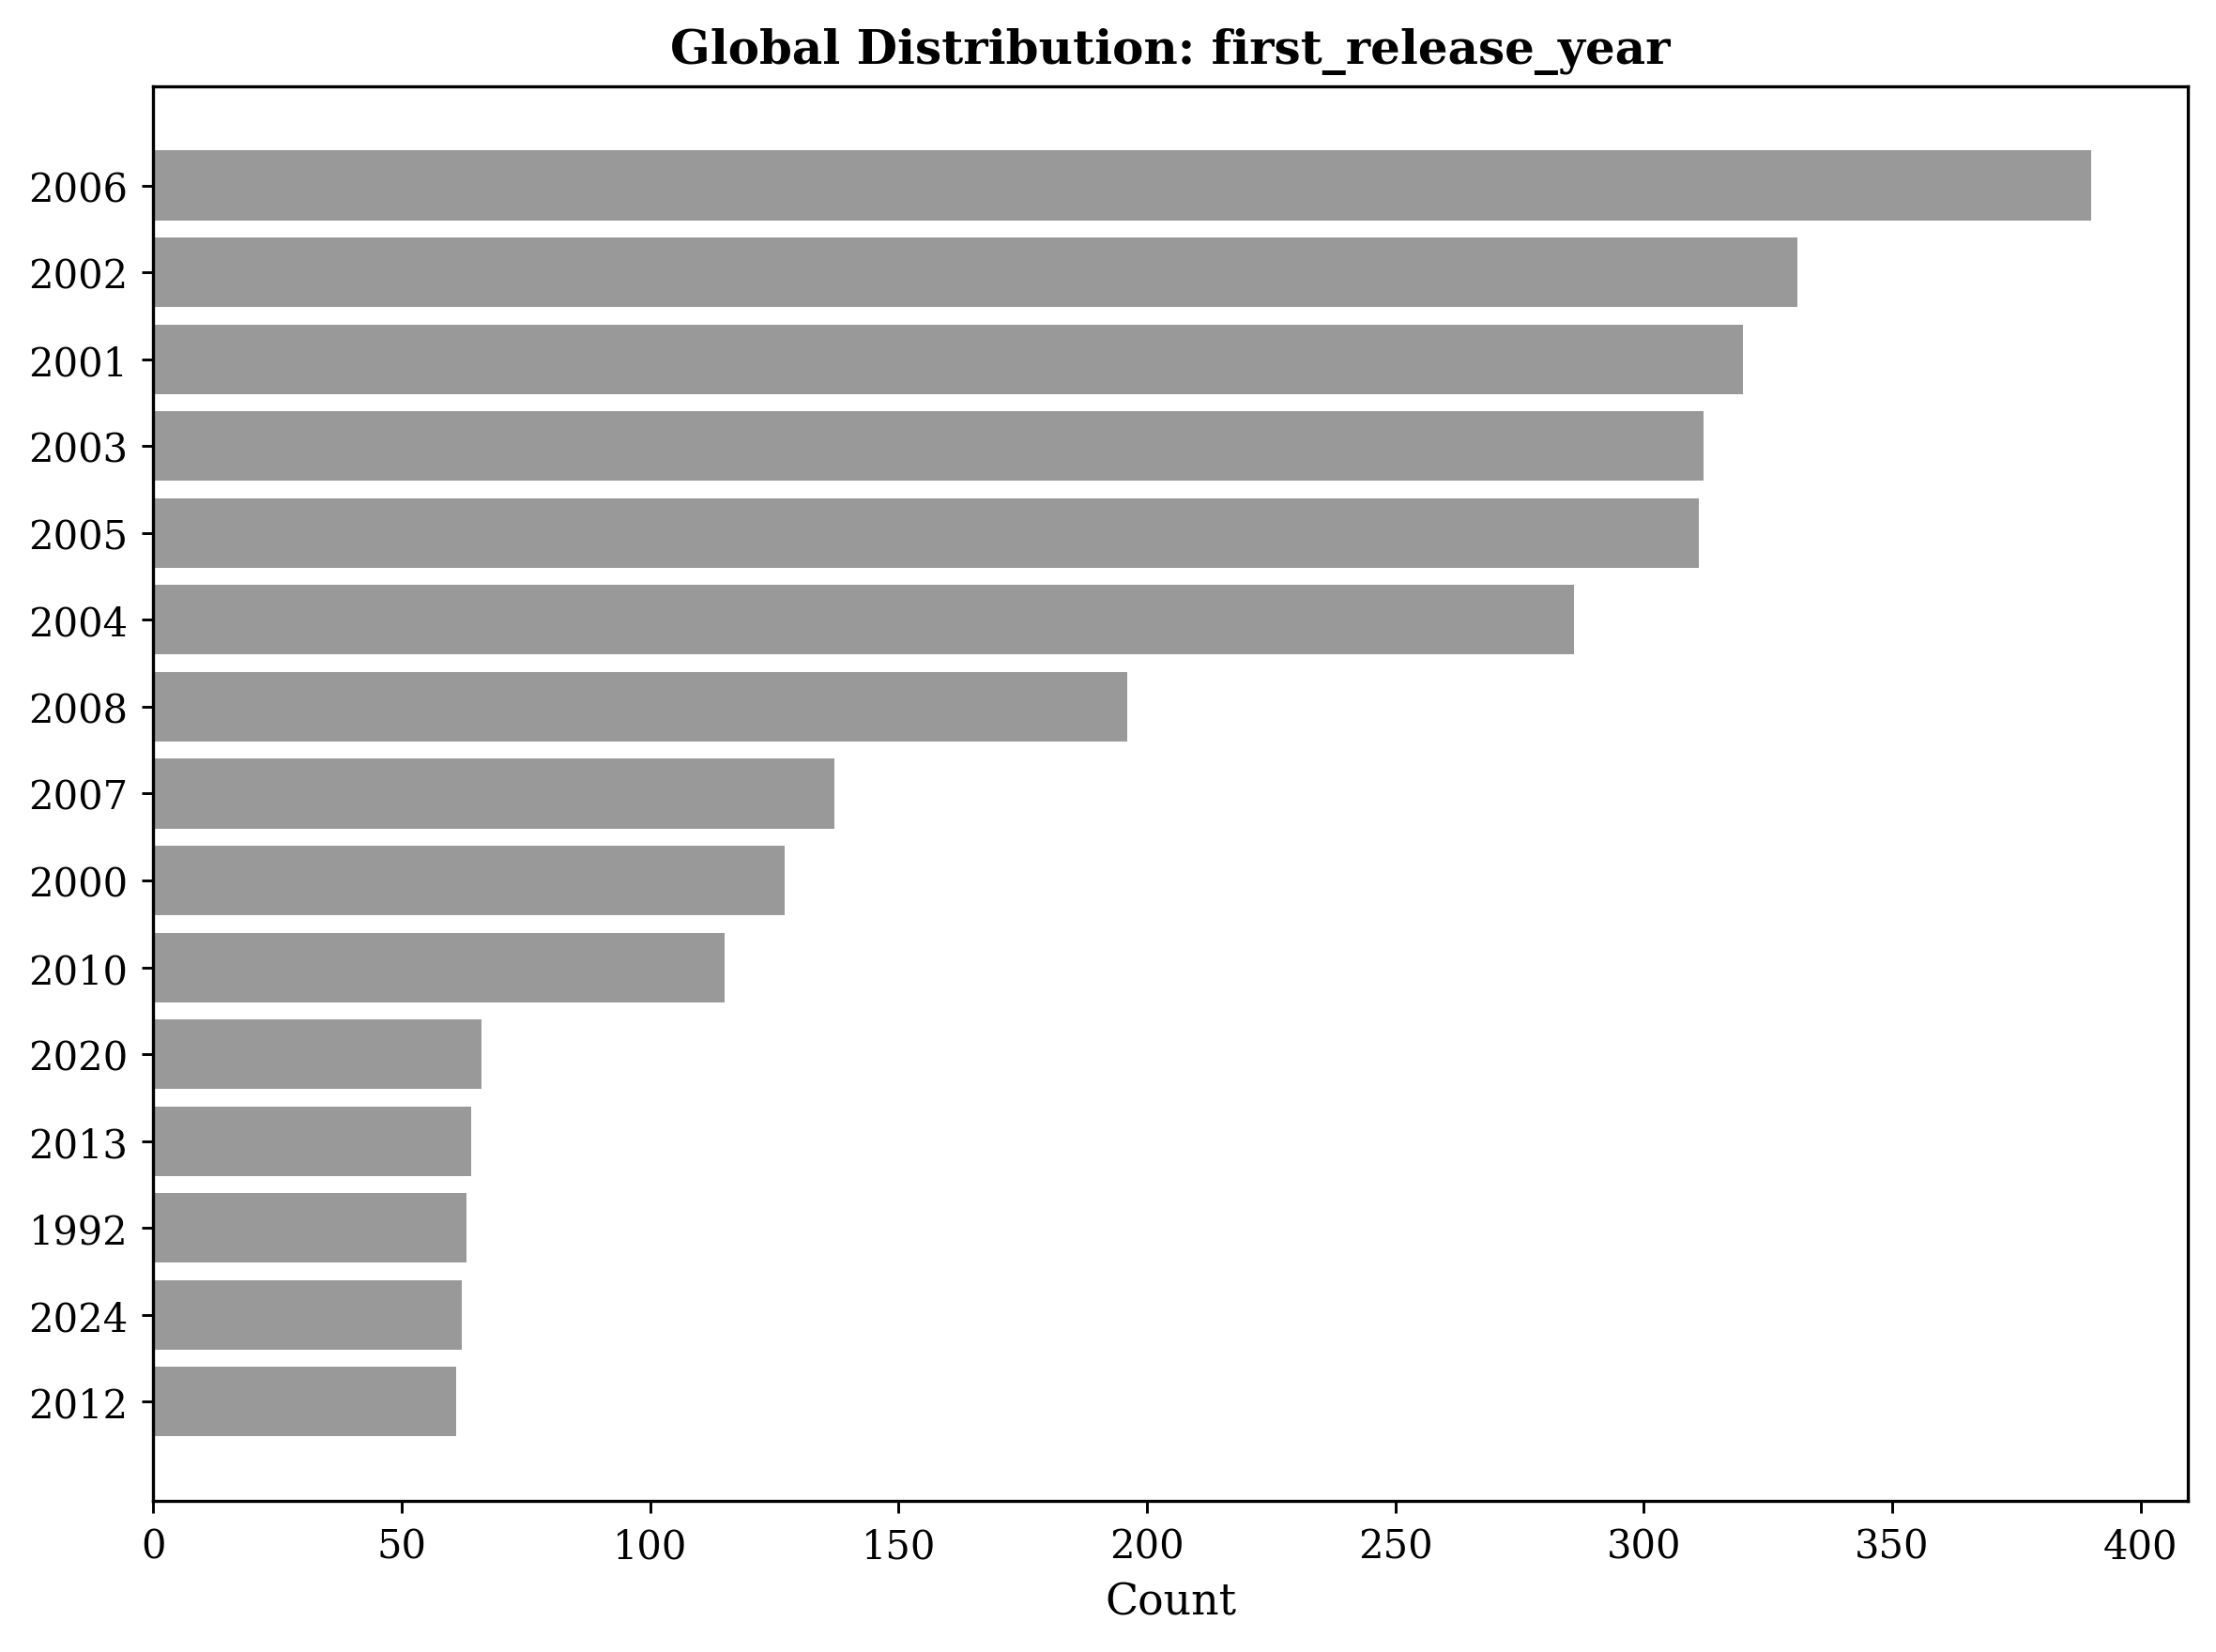

In [21]:
plot_global_metadata_eda(
    embeddings_dfs,
    columns = ["name", "rating", "themes", "keywords", "involved_companies", "first_release_year"],
    top_n=15,
    save_dir="results/report_figures",
    model_name="global"
)

5. % of outliers removed via mahalanobis method

In [28]:
n_components = 30
models = ['ctm', 'clap', 'ast', 'wavlm']
for model, X_raw in zip(models, [X_ctm, X_clap, X_ast, X_wavlm]):
    logger.info(f"Outlier removal test for model: {model}")
    outlier_removal_test(X_raw, alphas=[0.05, 0.01, 0.001], n_components=n_components)

2025-12-04 13:53:08.651 | INFO     | __main__:<module>:4 - Outlier removal test for model: ctm
2025-12-04 13:53:10.199 | INFO     | __main__:outlier_removal_test:109 - Alpha=0.05: Removed 388 outliers (11.69%) with χ² threshold=43.77
2025-12-04 13:53:10.211 | INFO     | __main__:outlier_removal_test:109 - Alpha=0.01: Removed 337 outliers (10.15%) with χ² threshold=50.89
2025-12-04 13:53:10.222 | INFO     | __main__:outlier_removal_test:109 - Alpha=0.001: Removed 299 outliers (9.01%) with χ² threshold=59.70
2025-12-04 13:53:10.222 | INFO     | __main__:<module>:4 - Outlier removal test for model: clap
2025-12-04 13:53:10.299 | INFO     | __main__:outlier_removal_test:109 - Alpha=0.05: Removed 416 outliers (12.48%) with χ² threshold=43.77
2025-12-04 13:53:10.312 | INFO     | __main__:outlier_removal_test:109 - Alpha=0.01: Removed 229 outliers (6.87%) with χ² threshold=50.89
2025-12-04 13:53:10.321 | INFO     | __main__:outlier_removal_test:109 - Alpha=0.001: Removed 114 outliers (3.42%) 